# Spike Time Dependent Plasticity
## Basic Experiments

In this notebook I'm going to implement some basic experiments related to the STDP algorithm from scratch.

The outline for this notebook is the following:
- Prelimainaries
    - Generic function for simulations
    - Default parameters
    - Plot utils
- Simple neurons models:
    - LIF neuron 
    - Poisson Neuron Model
- STDP algorithms
    - general simulation
    - STDP rule
- Turn the screw on STDP
    - ...
    - ...

In [1]:
%load_ext autoreload
%autoreload 2
# basic libraries
import os
import sys
import shutil
import time
import numpy as np
import pandas as pd

# graphics libraries
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
%config InlineBackend.figure_format='retina'
# use NMA plot style
#plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")
plt.style.use('seaborn-v0_8')
my_layout = widgets.Layout()
my_layout.width = '620px'

#import from my scripts
main_dir = os.getcwd()
if main_dir not in sys.path:
    print('Adding the folder for the modules')
    sys.path.append(main_dir)
import importlib

importlib.reload(importlib.import_module('neurons'))
importlib.reload(importlib.import_module('learning_rules'))
from neurons import *
from learning_rules import *

# show packages versions for python, numpy, and ipywidgets
print("Python: ", sys.version)
print("Numpy: ", np.__version__)
print("Pandas: ", pd.__version__)
print("IPywidgets: ", widgets.__version__)

Python:  3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
Numpy:  1.25.2
Pandas:  2.1.1
IPywidgets:  8.0.4


# Framework 

## Simulations on simple networks

I start by writing a function to study a given neuron type and a given weight update rule. I'm working with a network with `N_pre` presynaptic neuron (whose spike trains are controlled) and 1 post synaptic neuron.

This function generalizes the previous one allowing for multiple postsynaptic neurons `N_post`.

In [2]:
def simulation(
        pars,
        spk_input,                 # input spike train, a numpy vector of shape (time_steps, N_pre)
        neuron_type = LIFNeuron,   # class for the type of neuron 
        N_post = 1,                # number of post-synaptic neurons
        weight_rule = None,        # class for the weight update
        W_init = None,             # initial weights
        my_seed = 2024,            # seed for random number generation
        neuron_params = {},        # parameters for the neuron model
        weight_update_params = {}, # parameters for the weight update
):
    
    num_steps = np.shape(spk_input)[0]
    N_pre = np.shape(spk_input)[1]

    # Initialize the post synaptic neurons
    my_post_neuron = [ neuron_type(pars, **neuron_params) for i in range(N_post)]
    

    # Initialize the weights
    if W_init is None:
        np.random.seed(my_seed)
        W_init = np.random.rand(N_post, N_pre)
        W = W_init
    else:
        W = W_init 


    # Initialize the synapses with the given update rule
    if weight_rule is not None:
        my_synapses = weight_rule(pars, N_pre, N_post, W_init = W ,**weight_update_params)
    


    # start the simulation
    for t in range(num_steps):
        pre_spk = spk_input[t,:]
        I_inj = W @ pre_spk

        # colpo da maestro
        post_spk = [ my_post_neuron[i].forward(I_inj[i])[1] for i in range(N_post)]

        # update the weights
        if weight_rule is not None:
            my_synapses.update_weights([pre_spk, post_spk])
            W = my_synapses.W
        else:
            W = W
    if weight_rule is not None:
        return my_post_neuron, my_synapses
    else:
        return my_post_neuron



## Default parameters for the models

These are the parameters coming from neuroscience studies.

In [3]:
def default_pars(**kwargs):
    '''
    Define the default parameters
    values come from COURSE 2 
    '''

    pars = {}

    # typical neuron parameters
    pars['threshold'] = -55.    # spike threshold [mV]
    pars['tau_m'] = 10.         # membrane time constant [ms]
    pars['R'] = 0.1             # leak resistance [Ohm] with this resistance input current must be of the order of 100 mV
    pars['U_init'] = -65.       # initial potential [mV]
    pars['U_reset'] = -75.      # reset potential [mV]
    pars['U_resting'] = -75.    # leak reversal potential [mV]
    pars['t_ref'] = 5.          # refractory time (ms)

    # in the case of dynamic threshold
    pars['tau_thr'] = 20        # threshold time constant [ms]
    pars['ratio_thr'] = 1.1     # relative increment in the threshold due to a spike

    # in the case of soft reset
    ## ?? some way to lower the membrane potential not to a constant value
    
    # in case of noisy input
    pars['sigma'] = 1         # standard deviation of the noise

    # random seed
    pars['my_seed'] = 42

    # time steps
    pars['dt'] = 0.1             # simulation time step [ms]

    # for Poisson models
    pars['alpha'] = 0.1          # scaling factor for the membrane to the rate

    # STDP parameters
    pars['A_plus'] = 0.8                   # magnitude of LTP
    pars['A_minus'] = pars['A_plus'] * 1.10  # magnitude of LTD 
    pars['tau_plus'] = 20                    # LTP time constant [ms]
    pars['tau_minus'] = pars['tau_plus']     # LTD time constant [ms]

    # weight parameters
    pars['w_max'] = 1.            # maximum weight
    pars['w_min'] = 0.            # minimum weight


    # external parameters if any #
    for k in kwargs:
        pars[k] = kwargs[k]

    return pars


pars = default_pars()

These are the parameters we hope to use.

In [4]:
def simple_pars(**kwargs):
    '''
    Define the default parameters
    values come from COURSE 2 
    '''

    pars = {}

    # typical neuron parameters
    pars['threshold'] = 1.    # spike threshold [mV]
    pars['tau_m'] = 10.         # membrane time constant [ms]
    pars['R'] = 1            # leak resistance [Ohm] with this resistance input current must be of the order of 100 mV
    pars['U_init'] = 0       # initial potential [mV]
    pars['U_reset'] = 0.      # reset potential [mV]
    pars['U_resting'] = 0.    # leak reversal potential [mV]
    pars['t_ref'] = 2.          # refractory time (ms)

    # in the case of dynamic threshold
    pars['tau_thr'] = 20         # threshold time constant [ms]
    pars['ratio_thr'] = 1.1     # relative increment in the threshold due to a spike

    # in the case of soft reset
    ## ?? some way to lower the membrane potential not to a constant value

    # random seed
    pars['my_seed'] = 42

    # time steps
    pars['dt'] = 1             # simulation time step [ms]

    # for Poisson models
    pars['alpha'] = 0.1          # scaling factor for the membrane to the rate

    # STDP parameters
    pars['A_plus'] = 0.008                   # magnitude of LTP
    pars['A_minus'] = pars['A_plus'] * 1.10  # magnitude of LTD 
    pars['tau_plus'] = 20                    # LTP time constant [ms]
    pars['tau_minus'] = pars['tau_plus']     # LTD time constant [ms]

    # weight parameters
    pars['w_max'] = 1.            # maximum weight
    pars['w_min'] = 0.            # minimum weight


    # external parameters if any #
    for k in kwargs:
        pars[k] = kwargs[k]

    return pars

s_pars = simple_pars()

## Plot utilis

Here I group the functions to plot the graphics/interactive demos given a simulation.

First a basic raster plot for the input and output neurons.


In [5]:
# we are plotting the case in which we have the input spikes equal to the injected current
def raster_plot(
        pars, # parameters
        pre_syn_spk, # input spikes as array of 0,1 of shape (time_steps, N_pre) or as list of spike times
        post_syn_spk, # output spikes as array of 0,1 of shape (time_steps, N_post) or as list of spike times
        title = 'Raster plot',
        time_in_ms = False):
    
    """
    function to plot the raster plot of the input and output spikes
    INPUTS:
    - pars: parameters of the simulation
    - pre_syn_spk: input spikes as array of 0,1 of shape (time_steps, N_pre) or as list of spike times
    - post_syn_spk: output spikes as array of 0,1 of shape (time_steps, N_post) or as list of spike times
    - title: title of the plot
    """

    if time_in_ms:
        dt=pars['dt']
        label_x = 'Time (ms)'
    else:
        dt=1
        label_x = 'Time steps'

    # useful values
    N_pre = np.shape(pre_syn_spk)[1]
    if np.ndim(post_syn_spk) == 1:
        N_post = 1
        post_syn_spk = np.expand_dims(post_syn_spk, axis=1)
    else:
        N_post = np.shape(post_syn_spk)[1]
    time_steps = np.shape(pre_syn_spk)[0]

    # Generate Plots
    height_ratio = int(min(N_pre/ N_post,10))
    fig, ax = plt.subplots(2, figsize=(15,10), sharex=True, gridspec_kw = {'height_ratios': [height_ratio,1]})


    # convert spike record in spike times
    if type(pre_syn_spk) is list:
        pre_syn_spk_times = pre_syn_spk
    else:
        # note: even with 10000 presynaptic neurons and 10000 time steps this is not an heavy operation
        pre_syn_spk_times = [np.array(np.where(pre_syn_spk[:,i]==1)[0])*dt for i in range(N_pre)]
        
    ax[0].eventplot(pre_syn_spk_times, colors='black', lineoffsets=1,linewidth=1, linelengths=0.8, orientation='horizontal')
    # set y axis ticks corresponding to the neurons
    ax[0].set_yticks(np.arange(0, len(pre_syn_spk_times)+1, round(N_pre/10)))
    ax[0].set_ylabel("Input Spikes")
    ax[0].set_title(title)


    # Plot output spikes
    if type(post_syn_spk) is list:
        post_syn_spk_times = post_syn_spk
    else:
        post_syn_spk_times = [np.array(np.where(post_syn_spk[:,i]==1)[0])*dt for i in range(N_post)]
    ax[1].eventplot(post_syn_spk_times, colors='black', lineoffsets=1,linewidth=1, linelengths=0.8, orientation='horizontal')   
    ax[1].set_yticks(np.arange(0, N_post, max(round(N_post/10),1)))
    ax[1].set_ylabel("Output Spikes")
    ax[1].set_xlabel(label_x)

    plt.show()

Plot the weigths history.

In [14]:
def weights_plot(pars, weights_history,time_step = None, time_in_ms = False, title = None):
    """
    Plot the weights changes during the simulation

    INPUT:
    - pars: parameter dictionary
    - weights_history: synaptic weights over time for one post_synaptic neuron
    - spk_out: spike train of the post-synaptic neuron

    """

    # check if we want the time in ms
    if time_in_ms:
        dt=pars['dt']
        label_x = 'Time (ms)'
    else:
        dt=1
        label_x = 'Time steps'

    # useful values
    N_pre = weights_history.shape[1]
    num_steps = weights_history.shape[0]
    time_steps = np.arange(0, num_steps, 1)*dt

    # set the default time step
    if time_step is None:
        time_step = num_steps-10
    elif time_step > num_steps:
        print(f'Time step must be less than {num_steps}')
        return
    
    subsampling = 1

    fig,ax = plt.subplots(3, figsize=(12, 10), gridspec_kw={'height_ratios': [1, 2, 1]})#, sharex=True)

    fig.colorbar(ax[0].imshow(weights_history[:,:].T, cmap = 'viridis', aspect='auto'), ax=ax[0], orientation='vertical', fraction = 0.01, pad = 0.01)
    ax[0].set_xlabel(label_x)
    ax[0].axvline(time_step, 0., 1., color='red', ls='--')
    # remove the background grid
    ax[0].grid(False)
    ax[0].set_ylabel('Synaptic weights')
    if title:
        ax[0].set_title(title)
    else:
        ax[0].set_title('Synaptic weights over time')
    

    ax[1].plot(time_steps[::subsampling], weights_history[ ::subsampling,:], lw=1., alpha=0.7)
    ax[1].axvline(time_step, 0., 1., color='red', ls='--')
    ax[1].set_xlabel(label_x)
    ax[1].set_ylabel('Weight')

    w_min = np.min(weights_history[time_step,:])-0.1
    w_max = np.max(weights_history[time_step,:])+0.1
    width = (w_max - w_min)/51
    bins = np.arange(w_min, w_max, width)
    #g_dis, _ = np.histogram(weights_history[time_step,:], bins)
    #ax[1].bar(bins[1:], g_dis, color='b', alpha=0.5, width=width)
    ax[2].hist(weights_history[time_step,:], bins, color='b', alpha=0.5, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
    ax[2].set_xlabel('weights ditribution')
    ax[2].set_ylabel('Number')
    ax[2].set_title(f'Time step: {time_step}')
    plt.tight_layout()
    plt.show()
    





In [7]:
# function to plot pre and post synaptic traces
def plot_traces(pars, pre_trace_record, post_trace_record, trace_index_list = None, time_in_ms = False):
    """
    Plot the pre and post synaptic traces

    INPUT:
    - pars: parameter dictionary
    - pre_trace_record: synaptic traces of the pre-synaptic neurons
    - post_trace_record: synaptic traces of the post-synaptic neurons

    RETURN:
    Interactive demo, Visualization of synaptic traces
    """

    # check if we want the time in ms
    if time_in_ms:
        dt=pars['dt']
        label_x = 'Time (ms)'
    else:
        dt=1
        label_x = 'Time steps'

    # check the index of the trace to higlight
    if trace_index_list is None:
        trace_index_list = [0]
    elif max(trace_index_list) > pre_trace_record.shape[1]:
        print(f'Trace indexes must be less than {pre_trace_record.shape[1]}')
        return
    n = len(trace_index_list)
    
    # useful values
    num_steps = pre_trace_record.shape[0]
    time_steps = np.arange(0, num_steps, 1)*dt

    fig,ax = plt.subplots(2, figsize=(12, 10), sharex=True)

    ax[0].plot(time_steps, pre_trace_record, lw=1., alpha=0.05)
    df = pd.DataFrame(pre_trace_record[:,trace_index_list])
    df.plot(ax=ax[0], color = ['r','g', 'b'], lw=1., alpha=1, legend=False)
    #ax[0].plot(time_steps, , lw=1., alpha=1)#, color = 'r')
    ax[0].set_title(f'Pre-synaptic traces - {n} higlighted')
    ax[0].set_xlabel(label_x)
    ax[0].set_ylabel('Pre traces')


    ax[1].plot(time_steps, post_trace_record, lw=1., alpha=0.7)
    ax[1].set_title('Post-synaptic traces')
    ax[1].set_xlabel(label_x)
    ax[1].set_ylabel('Post traces')

    plt.tight_layout()
    plt.show()




# Simple Neuron Models

I'll start implementing the neurons as python functions, therefore I'll move to class syntax. 

## LIF neuron

We can see the overall raster plot.

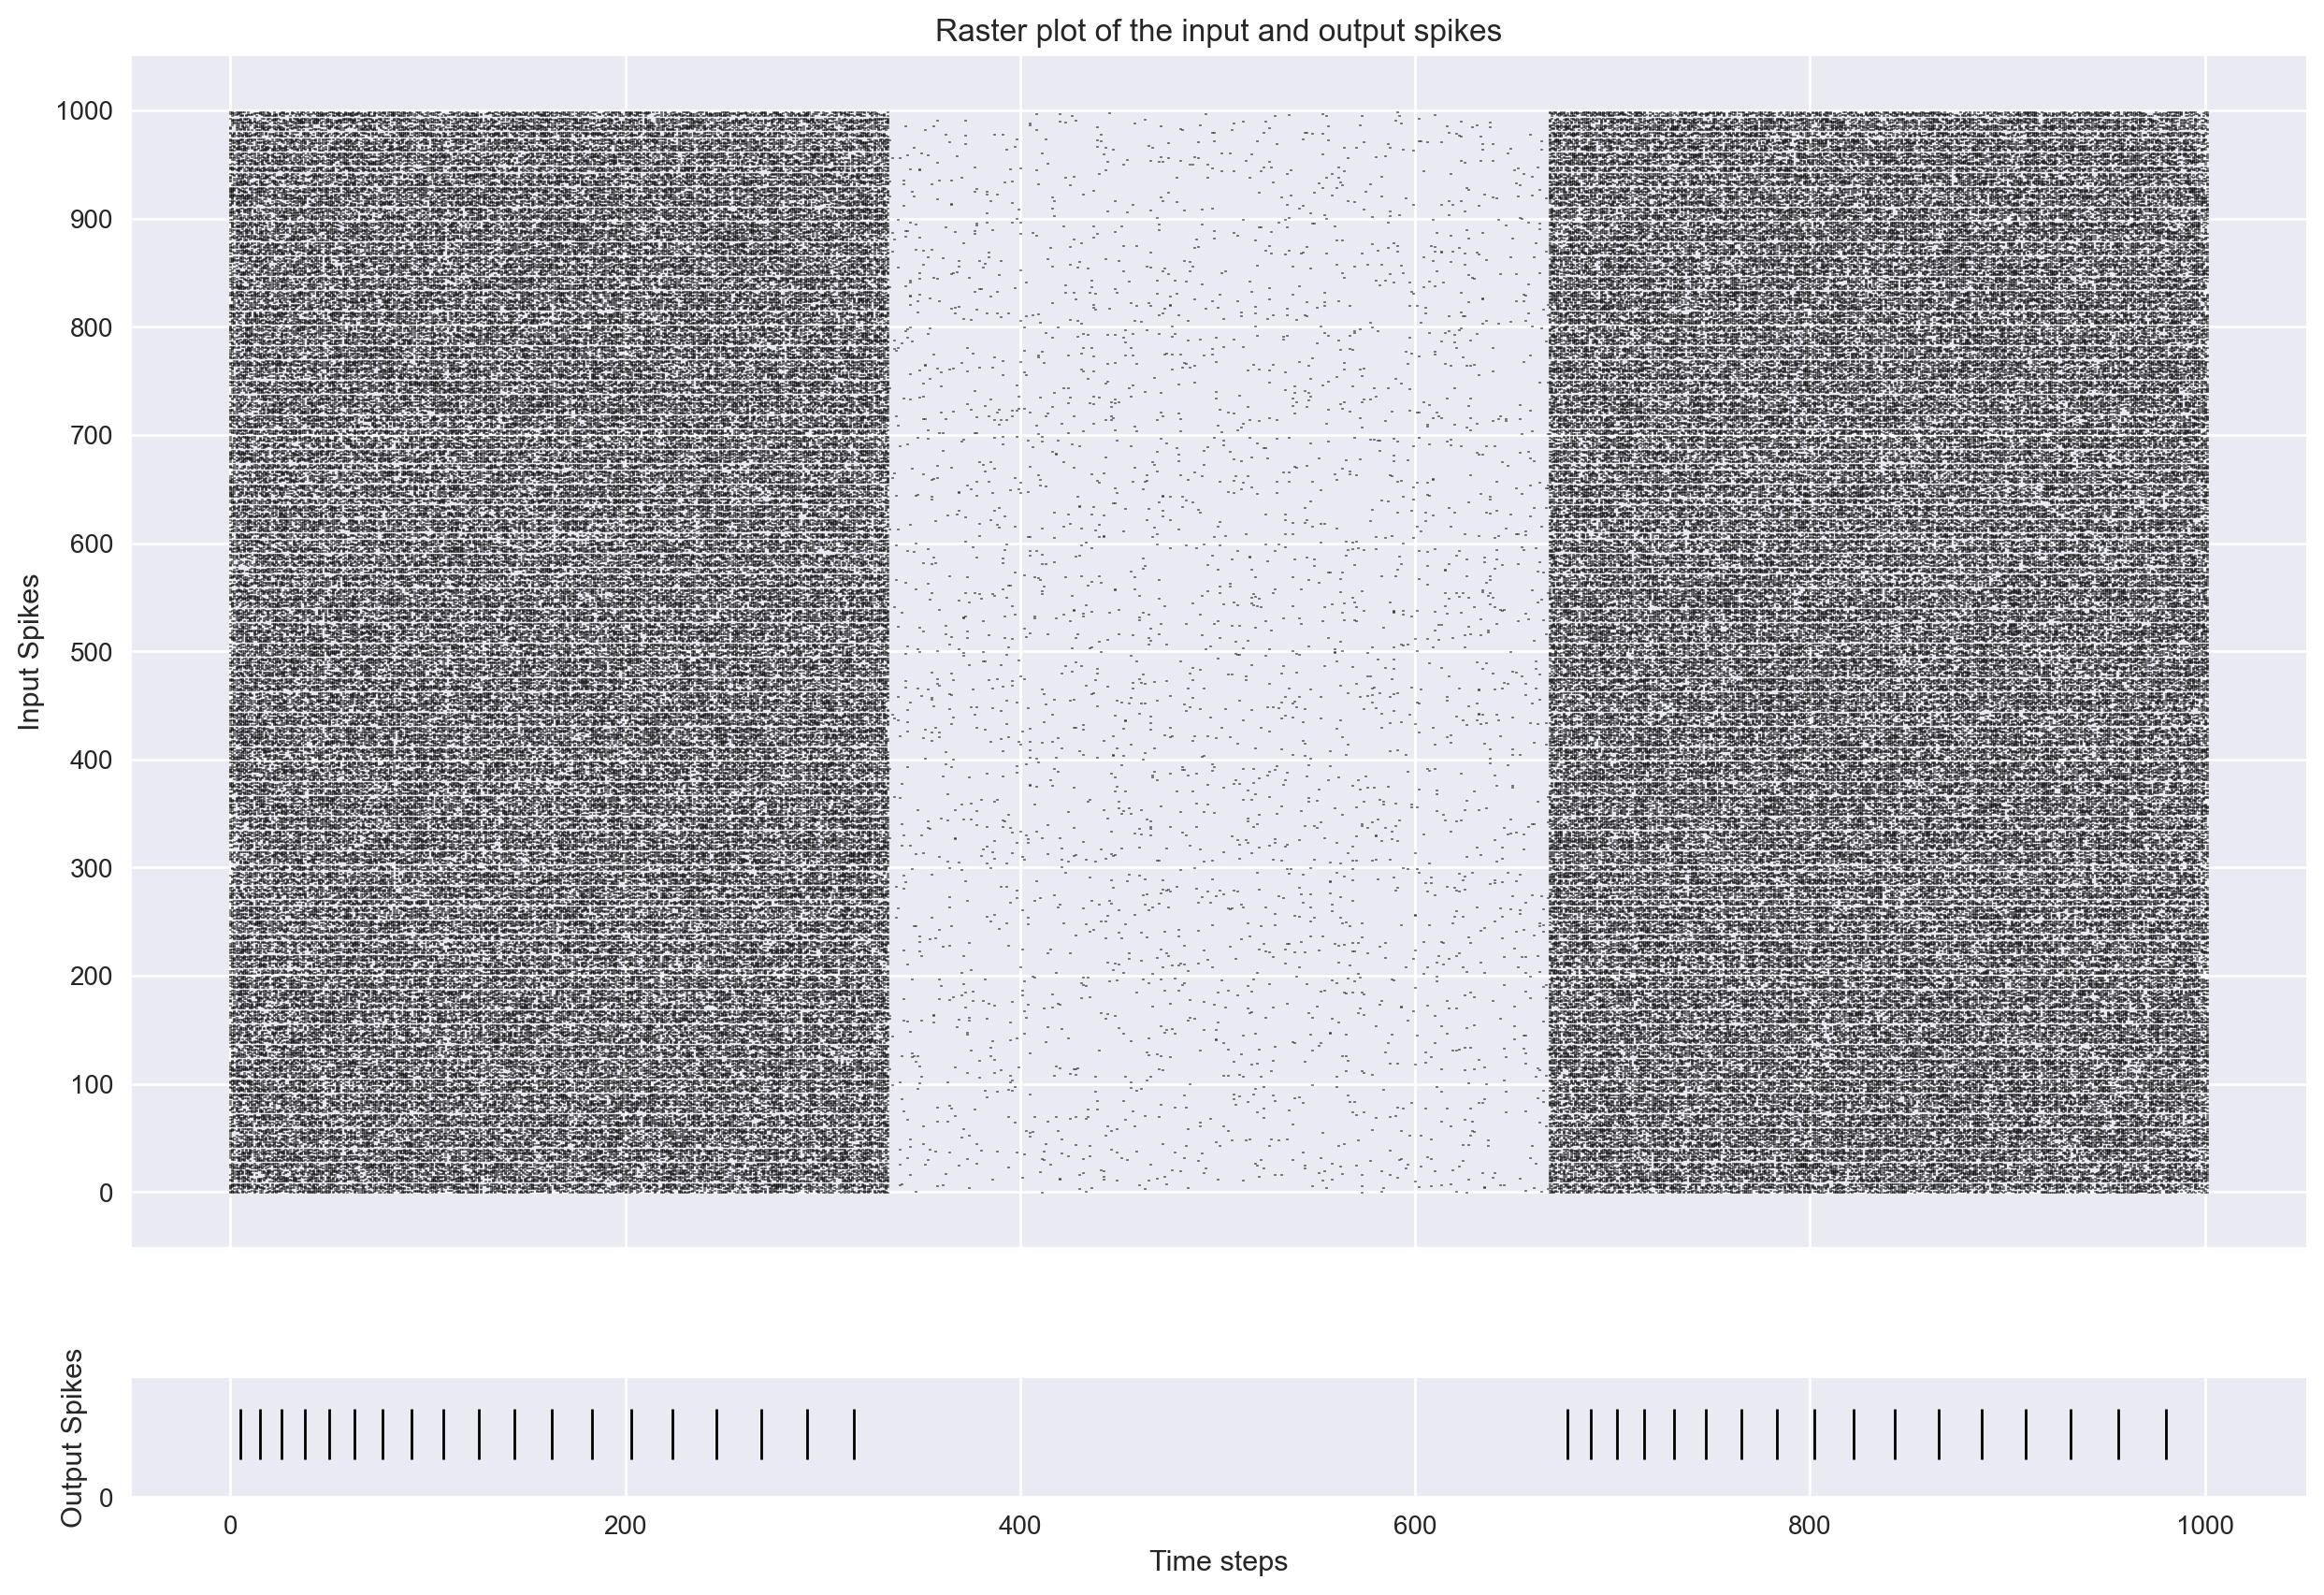

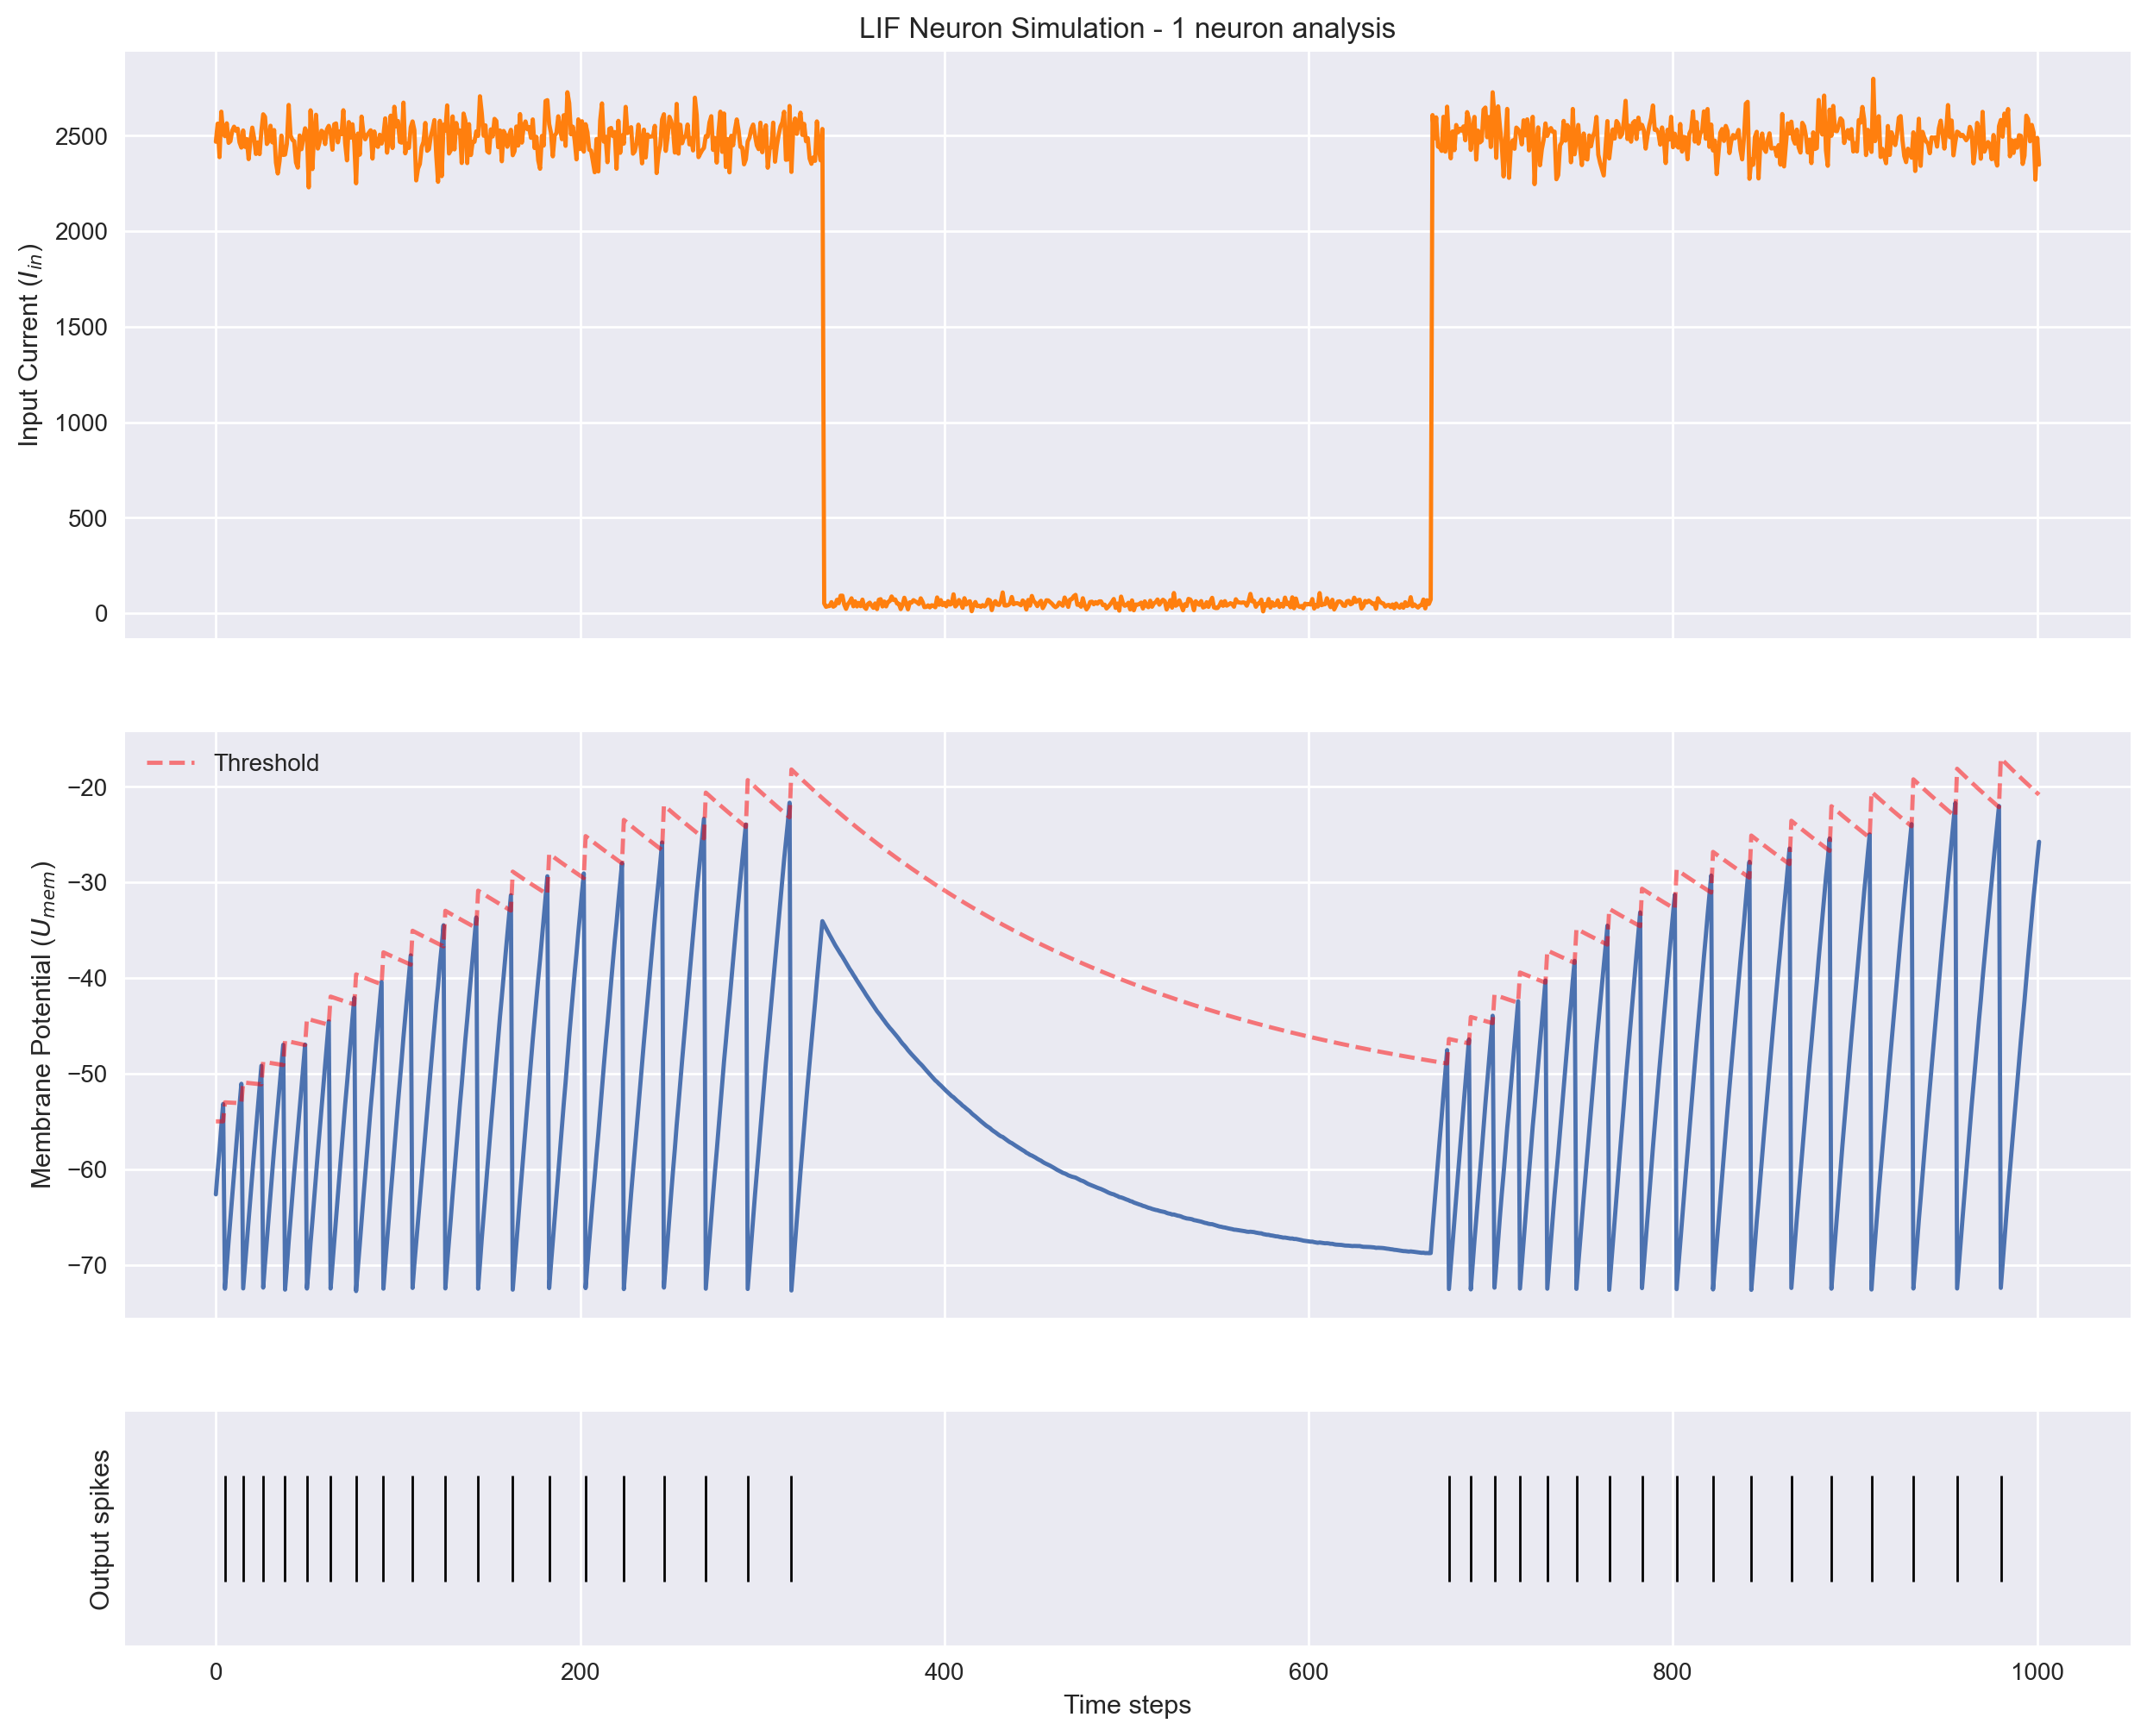

In [8]:
N_pre = 1000
N_post = 1
num_steps = 1002 # that is 100 milliseconds
#I = np.ones((time_steps,N_pre))
I = np.concatenate([np.round(np.random.random((num_steps//3,N_pre))), np.round(np.random.random((num_steps//3,N_pre))-0.49),np.round(np.random.random((num_steps//3,N_pre)))], axis=0) 

# random spike train with spike probability 0.5 in the first half and 0.2 in the second half#
pars = default_pars()
#pars = simple_pars(ratio_thr = 1.5, t_ref=5, tau_thr = 40)

# run the base simulation
lif= simulation(pars, I, W_init=np.random.random((1,N_pre))*10, 
                        neuron_params = {'refractory_time': False, 'dynamic_threshold': True, 'hard_reset':True})


raster_plot(pars, I, lif[0].get_records()['spk'], title = 'Raster plot of the input and output spikes')

lif[0].plot_records(title="LIF Neuron Simulation - 1 neuron analysis")

Simulation with more output neurons:

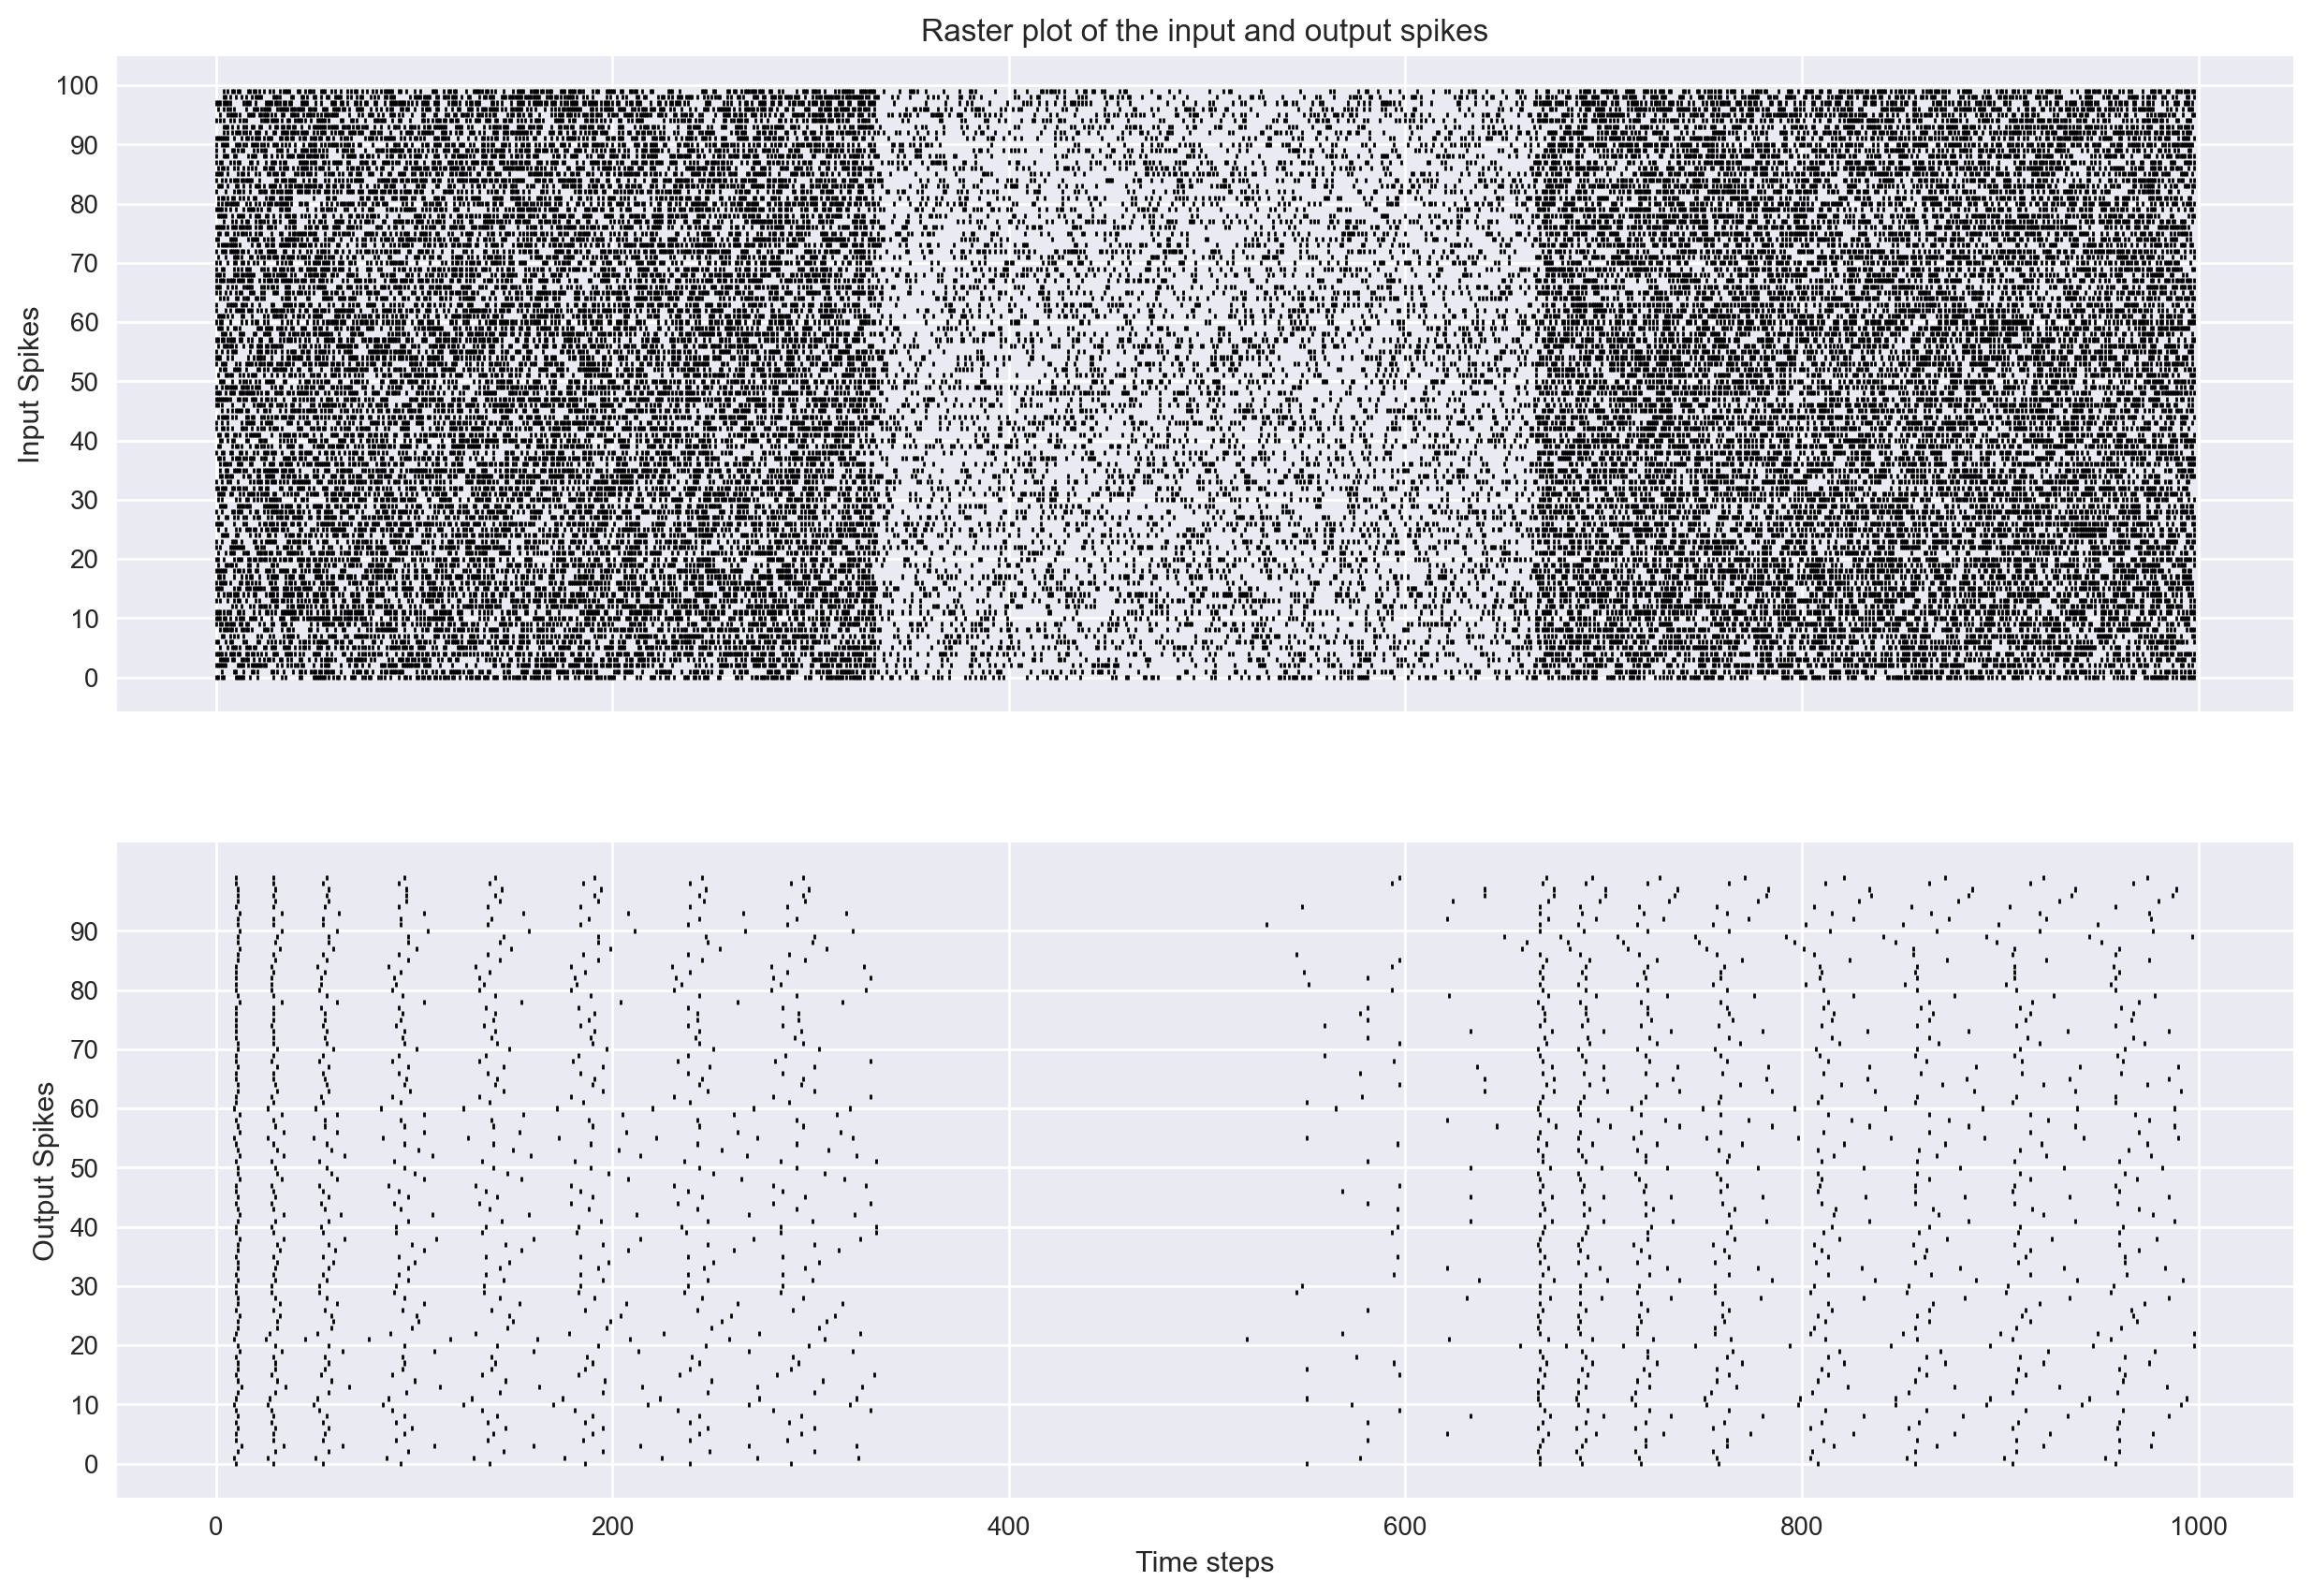

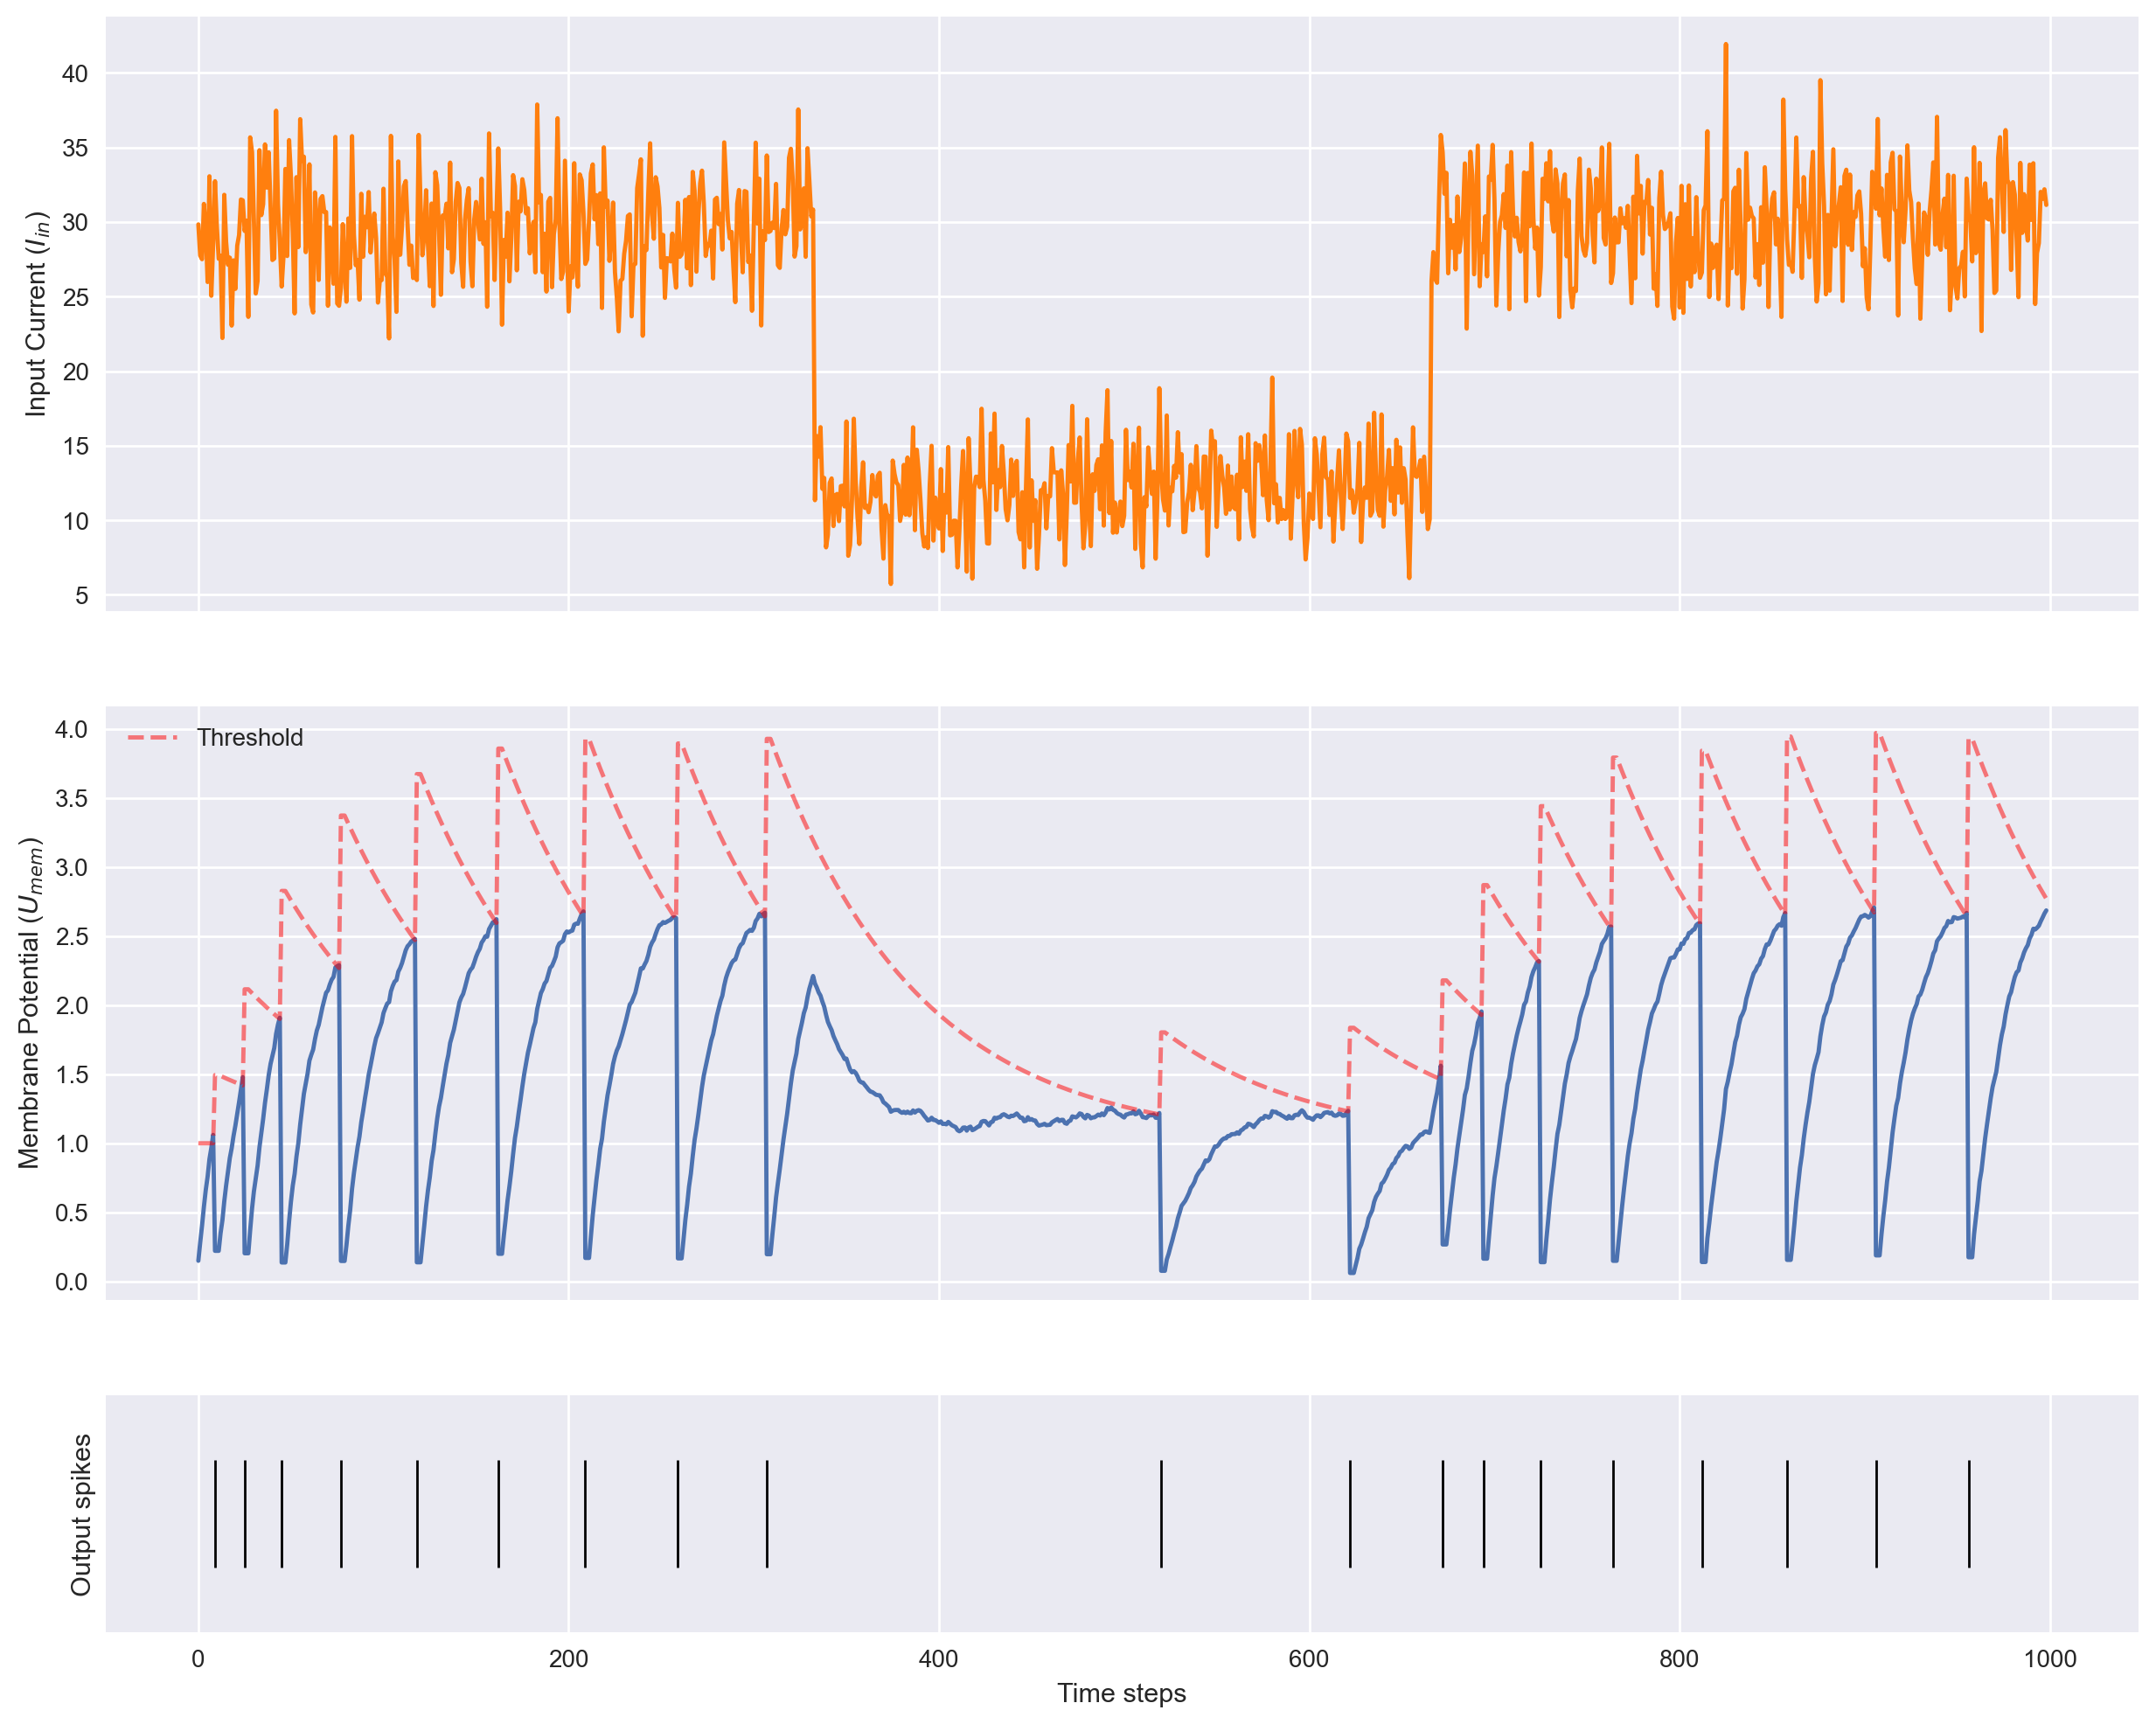

In [9]:
N_pre = 100
num_steps = 1000
N_post = 100
I = np.concatenate([np.round(np.random.random((num_steps//3,N_pre))), np.round(np.random.random((num_steps//3,N_pre))-0.30),np.round(np.random.random((num_steps//3,N_pre)))], axis=0) 
pars = simple_pars(R = 0.1, tau_thr = 40, dt = 0.5, ratio_thr = 1.5)
neurons = simulation(pars , N_post = N_post, spk_input= I , neuron_type=LIFNeuron,
                     neuron_params = {'refractory_time': True, 'dynamic_threshold': True, 'hard_reset':False})

raster_plot(pars, I, np.array([neurons[i].get_records()['spk'] for i in range(N_post)]).T, title = 'Raster plot of the input and output spikes')

neurons[21].plot_records()

## Poisson Neuron Model

First we will need a function to generate Poisson Spike Trains.

In [10]:
def Poisson_generator(pars, rate, n, num_steps, myseed=False, herz_rate = False):
    """Generates poisson trains

    Args:
    pars            : parameter dictionary
    rate            : float or array of shape (n) of spiking rate as prob pre bin or [Hz], constant in time for each spike train 
    n               : number of Poisson trains (N_pre)
    myseed          : random seed. int or boolean

    Returns:
    pre_spike_train : spike train matrix, ith row represents whether
                        there is a spike in ith spike train over time
                        (1 if spike, 0 otherwise)
    """

    # Retrieve simulation parameters
    dt = pars['dt']

    # set random seed
    if myseed:
        np.random.seed(seed=myseed)
    else:
        np.random.seed()

    # generate random variables uniformly distributed in [0,1]
    u_rand = np.random.rand(num_steps, n)

    # check if the rate is in Hz or in probability per bin
    if herz_rate:
        rate_per_bin = rate * (dt / 1000.)
    else:
        rate_per_bin = rate 
    
    # generate Poisson train
    poisson_train = 1. * (u_rand < rate_per_bin)

    return poisson_train


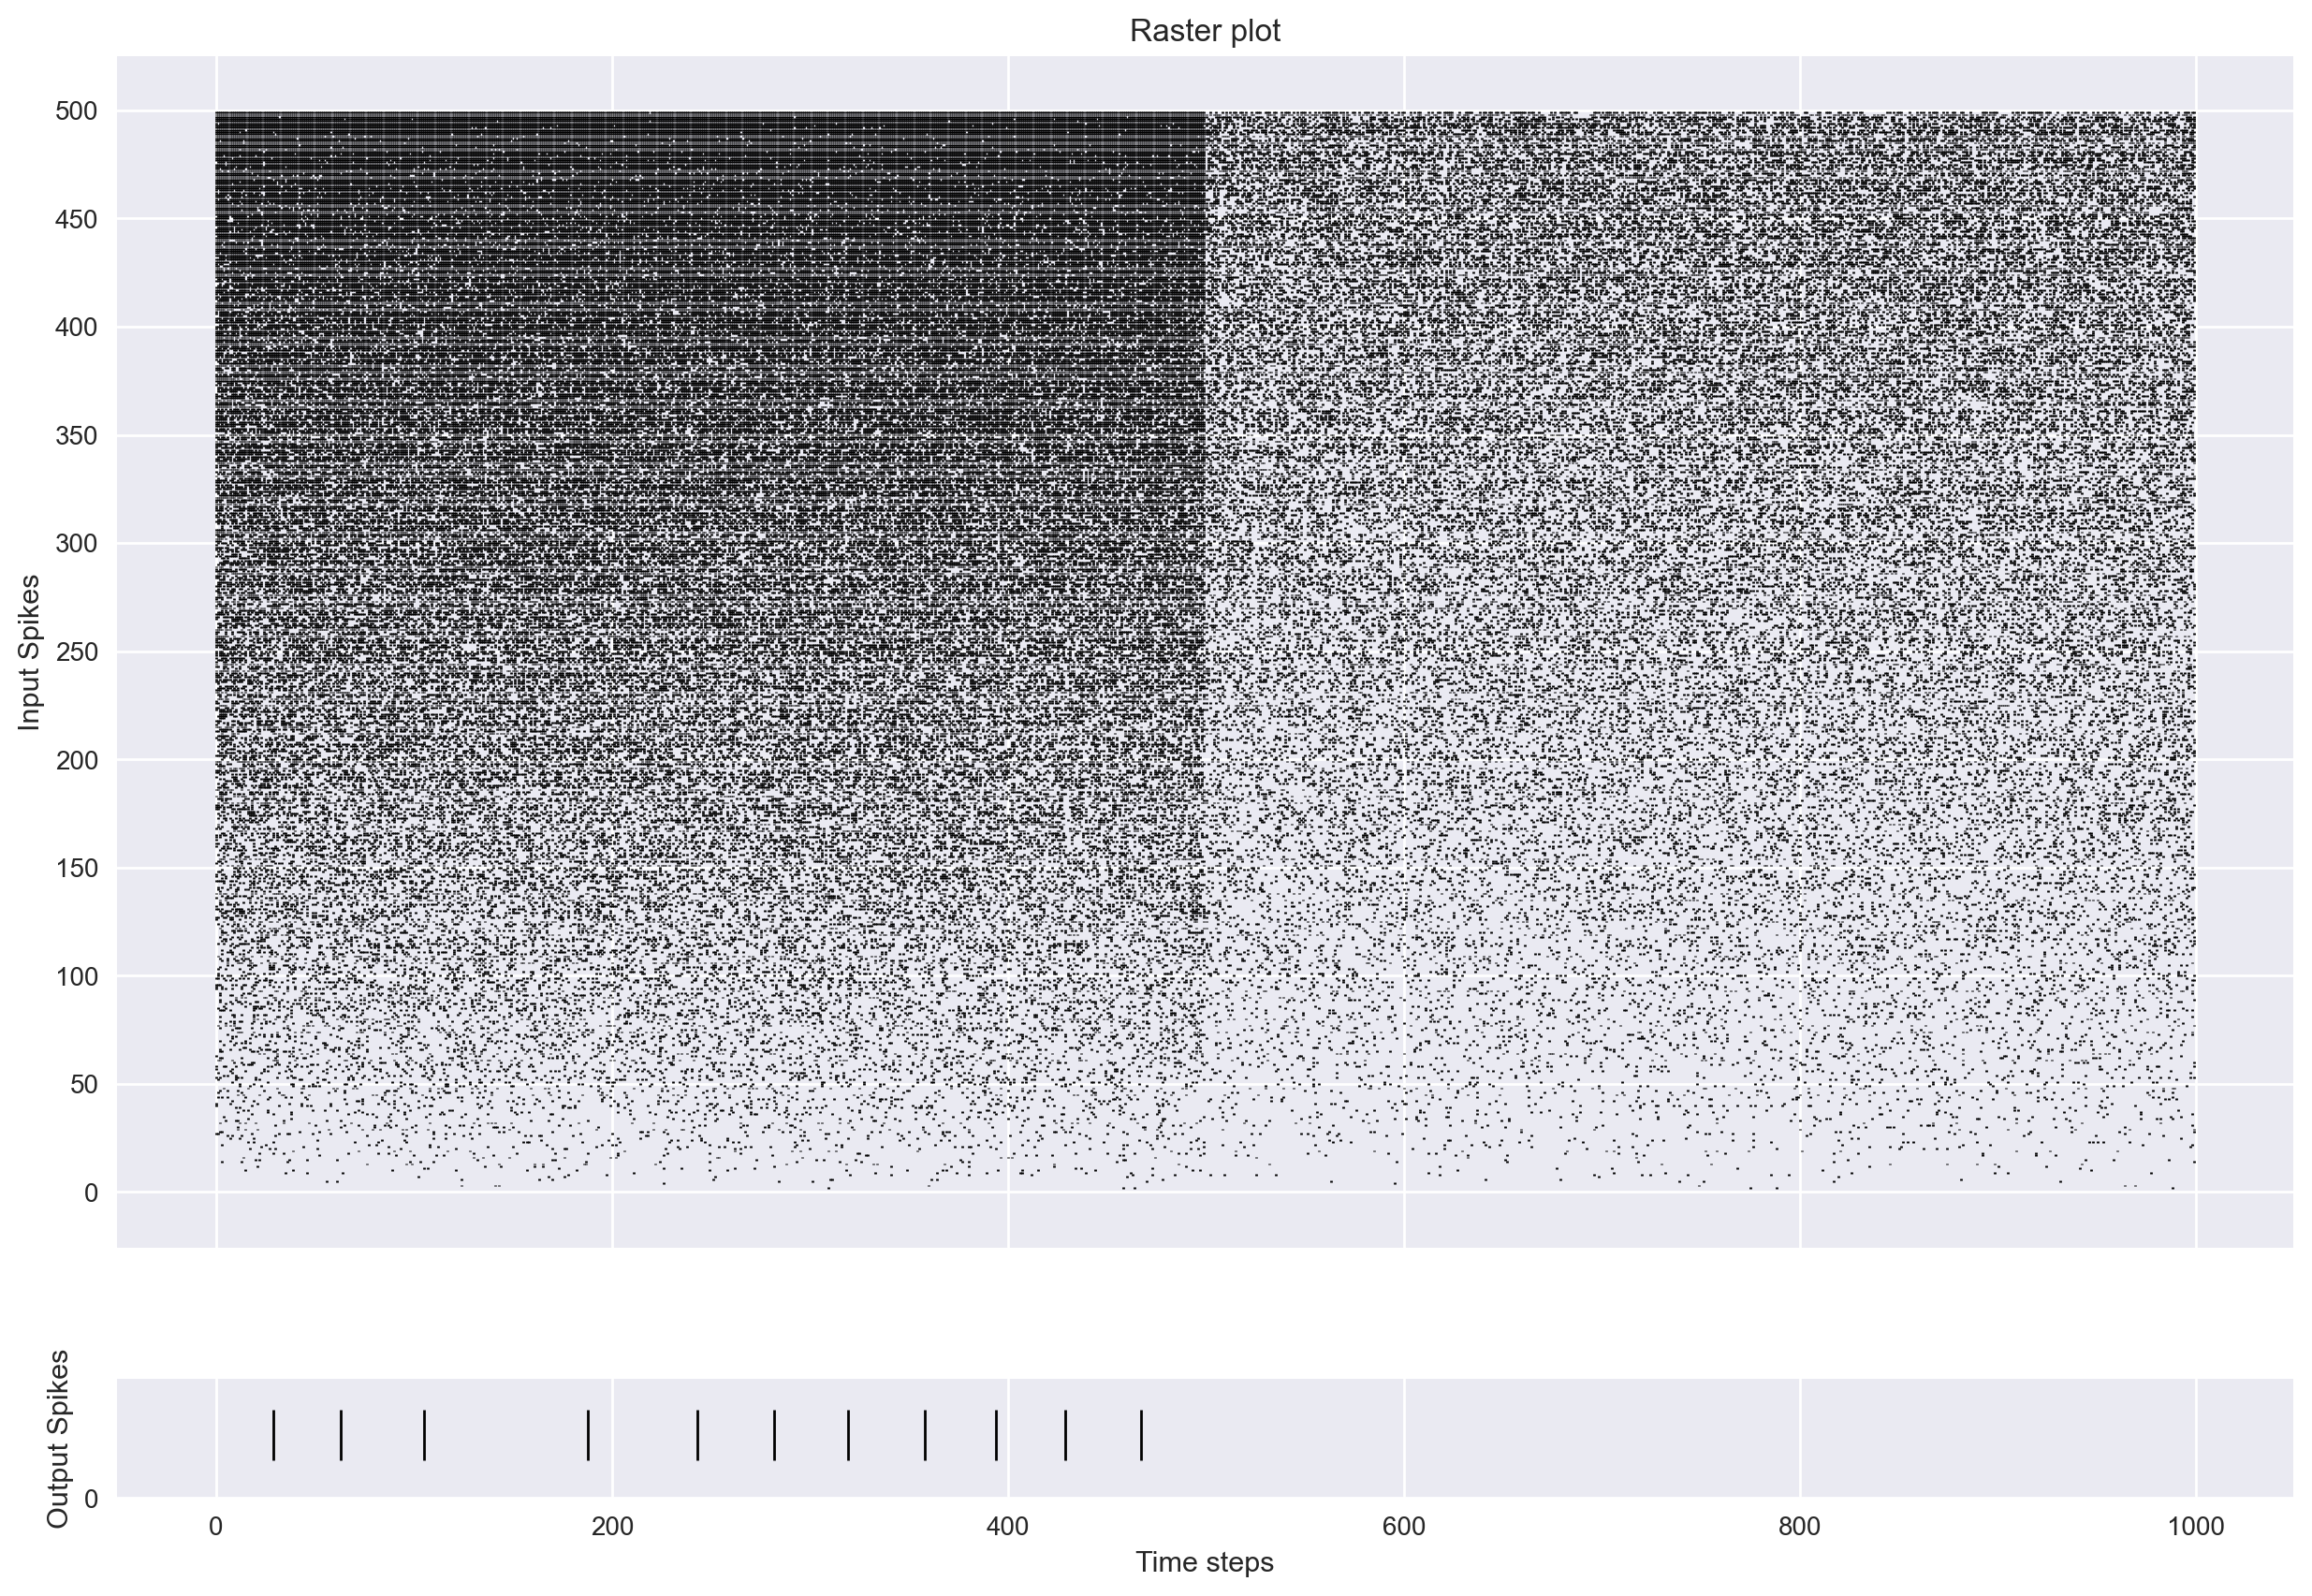

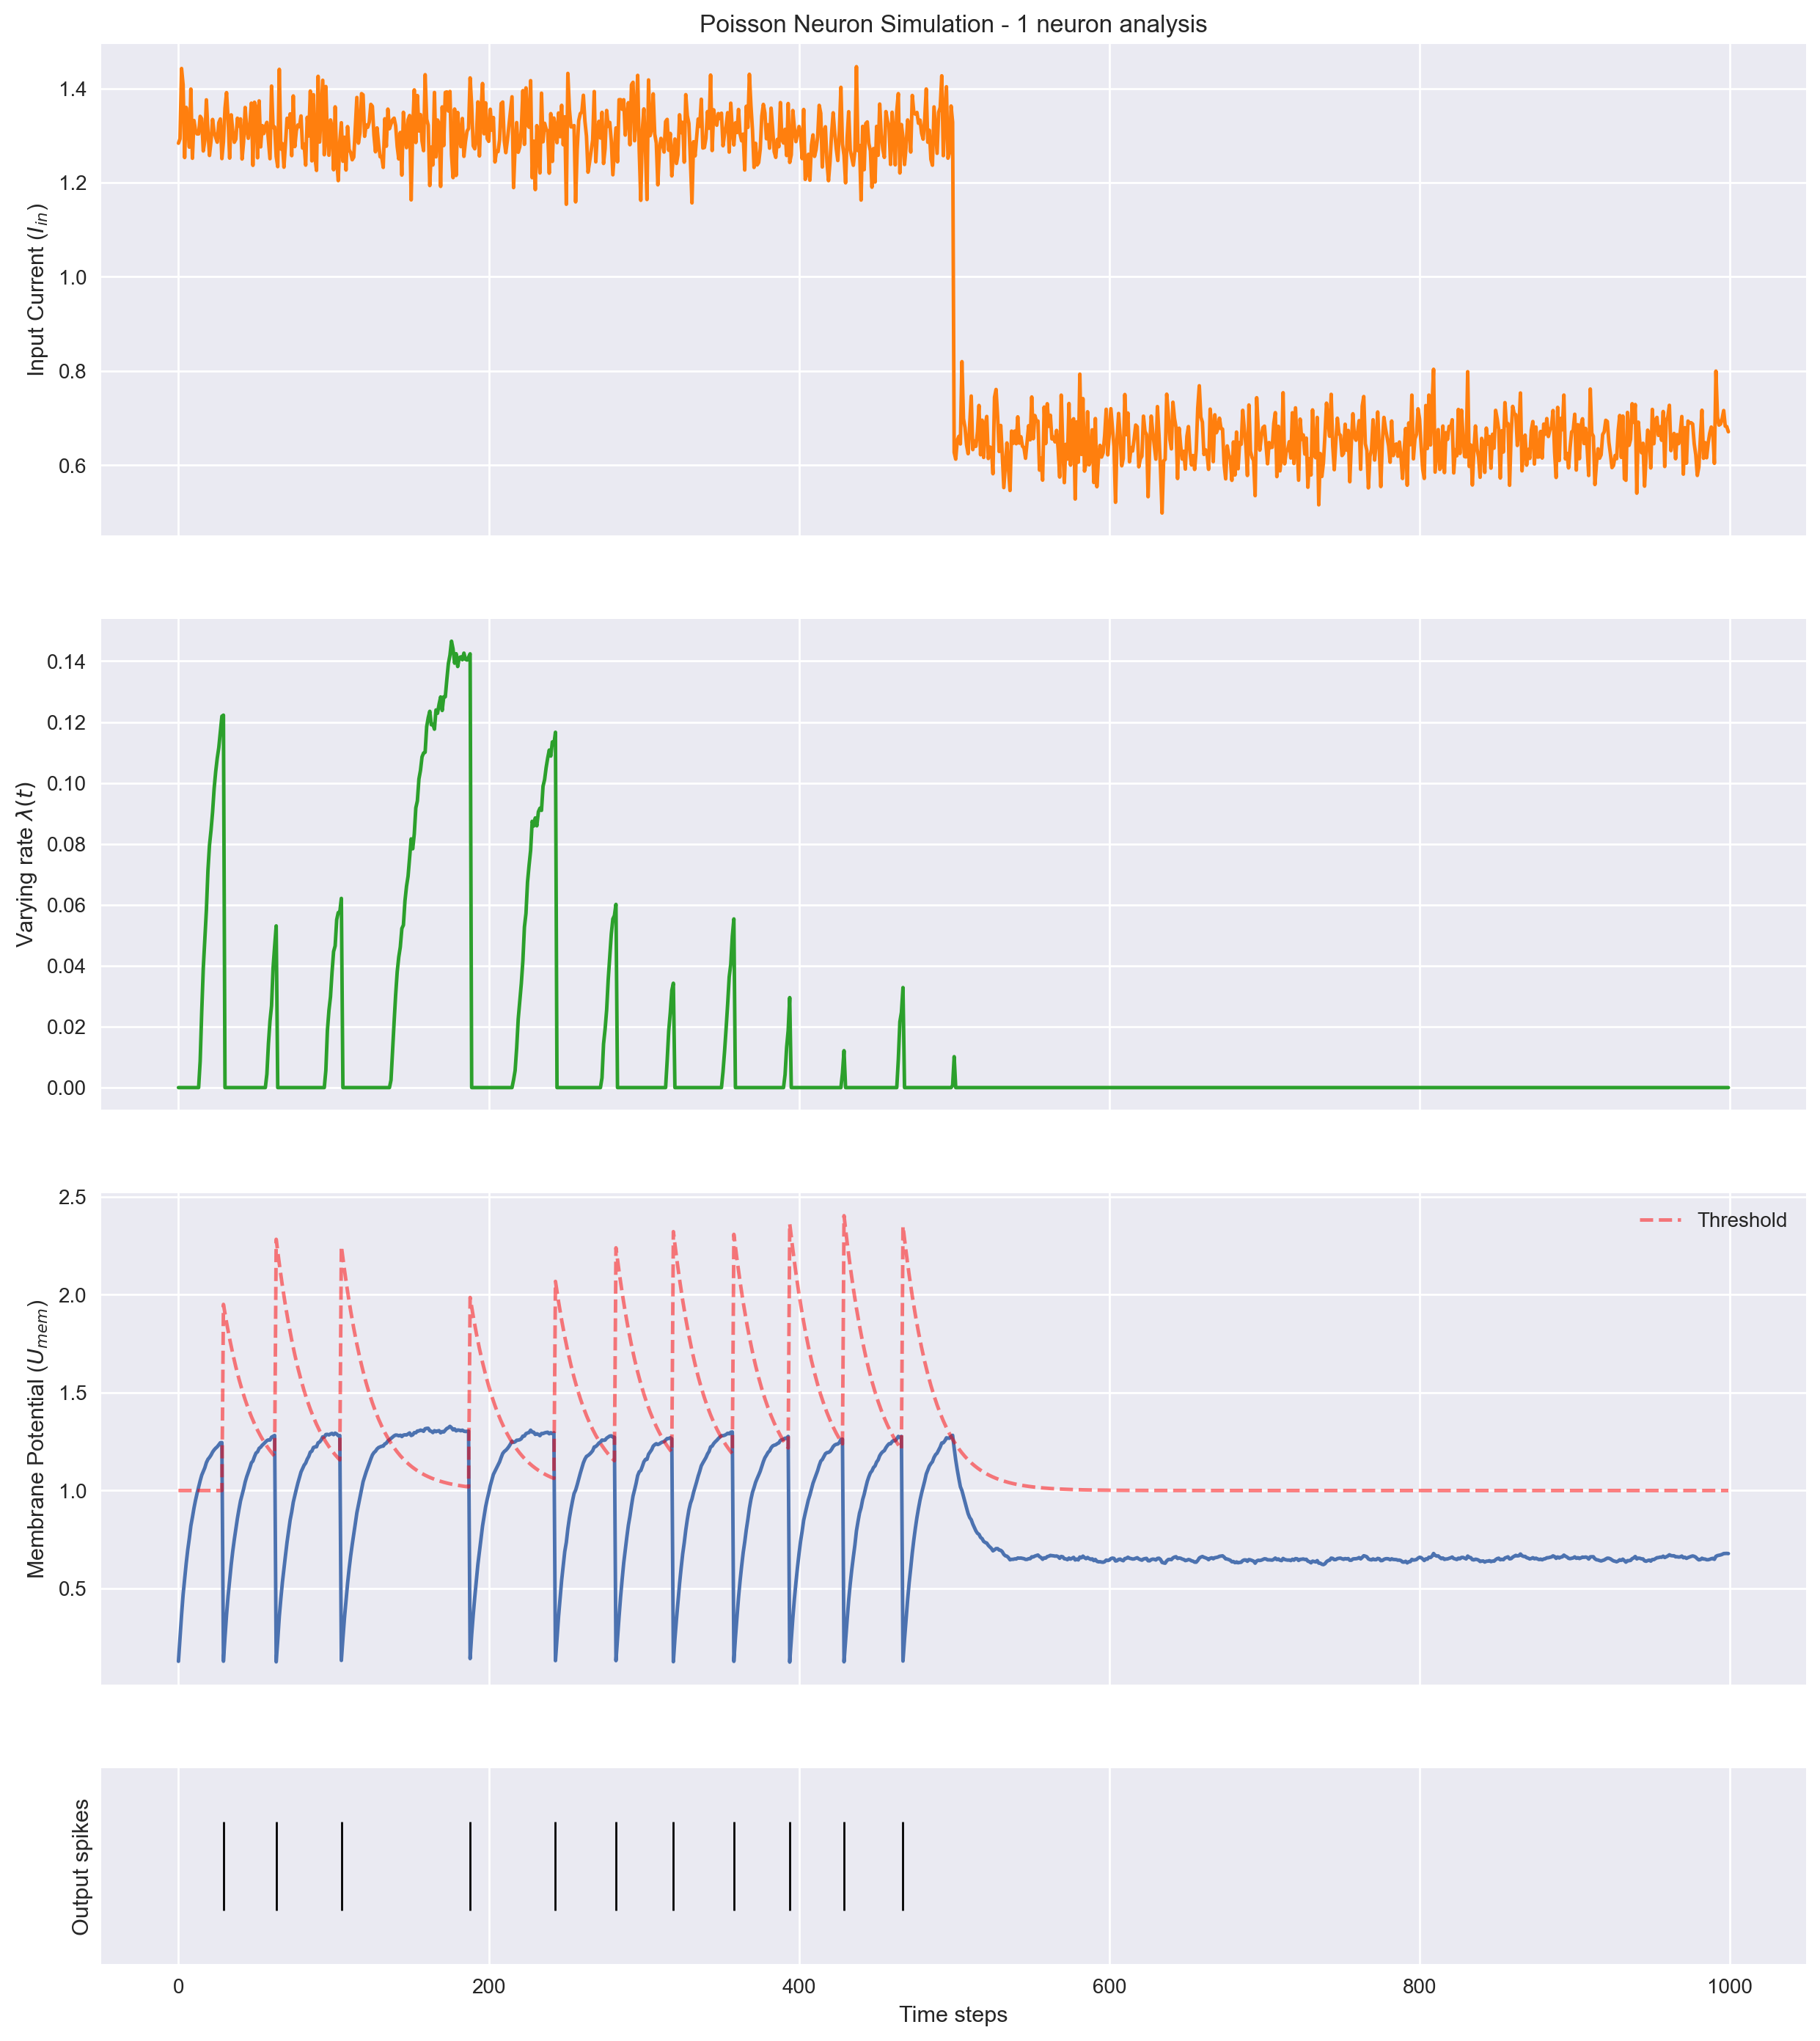

In [11]:
# simple Poisson simulation and plot
N_pre = 500
time_steps = 1000  # that is 100 milliseconds
#pars = default_pars()
pars = simple_pars(alpha = 0.5, t_ref=2, ratio_thr = 2)
rate = np.arange(0,N_pre,1)/N_pre
I = np.concatenate([Poisson_generator(pars, rate = rate, n = N_pre, num_steps = time_steps//2), Poisson_generator(pars, rate = rate/2, n = N_pre, num_steps = time_steps//2)], axis=0) 
# random spike train with spike probability 0.5 in the first half and 0.2 in the second half

poisson = simulation(pars, I, neuron_type = PoissonNeuron, W_init=np.random.random((1,N_pre))*0.01,
                            neuron_params = {'refractory_time': False, 'dynamic_threshold': True, 'hard_reset':True})

raster_plot(s_pars, I, poisson[0].get_records()['spk'])

poisson[0].plot_records(title="Poisson Neuron Simulation - 1 neuron analysis")

# Spike time based algorithms

We now can implement the STDP update rule, which relies on the pre and post synaptic traces of the neurons.

In [12]:
# simple Poisson simulation and plot
N_pre = 300
num_steps = 1000  # that is 100 milliseconds
N_post = 100

#pars = default_pars()
pars = simple_pars( A_plus = 0.01, A_minus = 0.019, tau_plus = 20, tau_minus = 20, w_max = 10, w_min = 0.001, R = 10)
rate = np.arange(0,N_pre,1)/N_pre
I = np.concatenate([Poisson_generator(pars, rate = rate, n = N_pre, num_steps = num_steps//2), Poisson_generator(pars, rate = rate/2, n = N_pre, num_steps = num_steps//2)], axis=0)
# simple Poisson simulation and plot
#pars = default_pars()
rate = np.arange(1,N_pre+1,1)/N_pre
I = np.concatenate([Poisson_generator(pars, rate = rate, n = N_pre, num_steps = num_steps//2), Poisson_generator(pars, rate = rate/2, n = N_pre, num_steps = num_steps//2)], axis=0) 
# random spike train with spike probability 0.5 in the first half and 0.2 in the second half
W_init = np.random.random((N_post,N_pre)) 




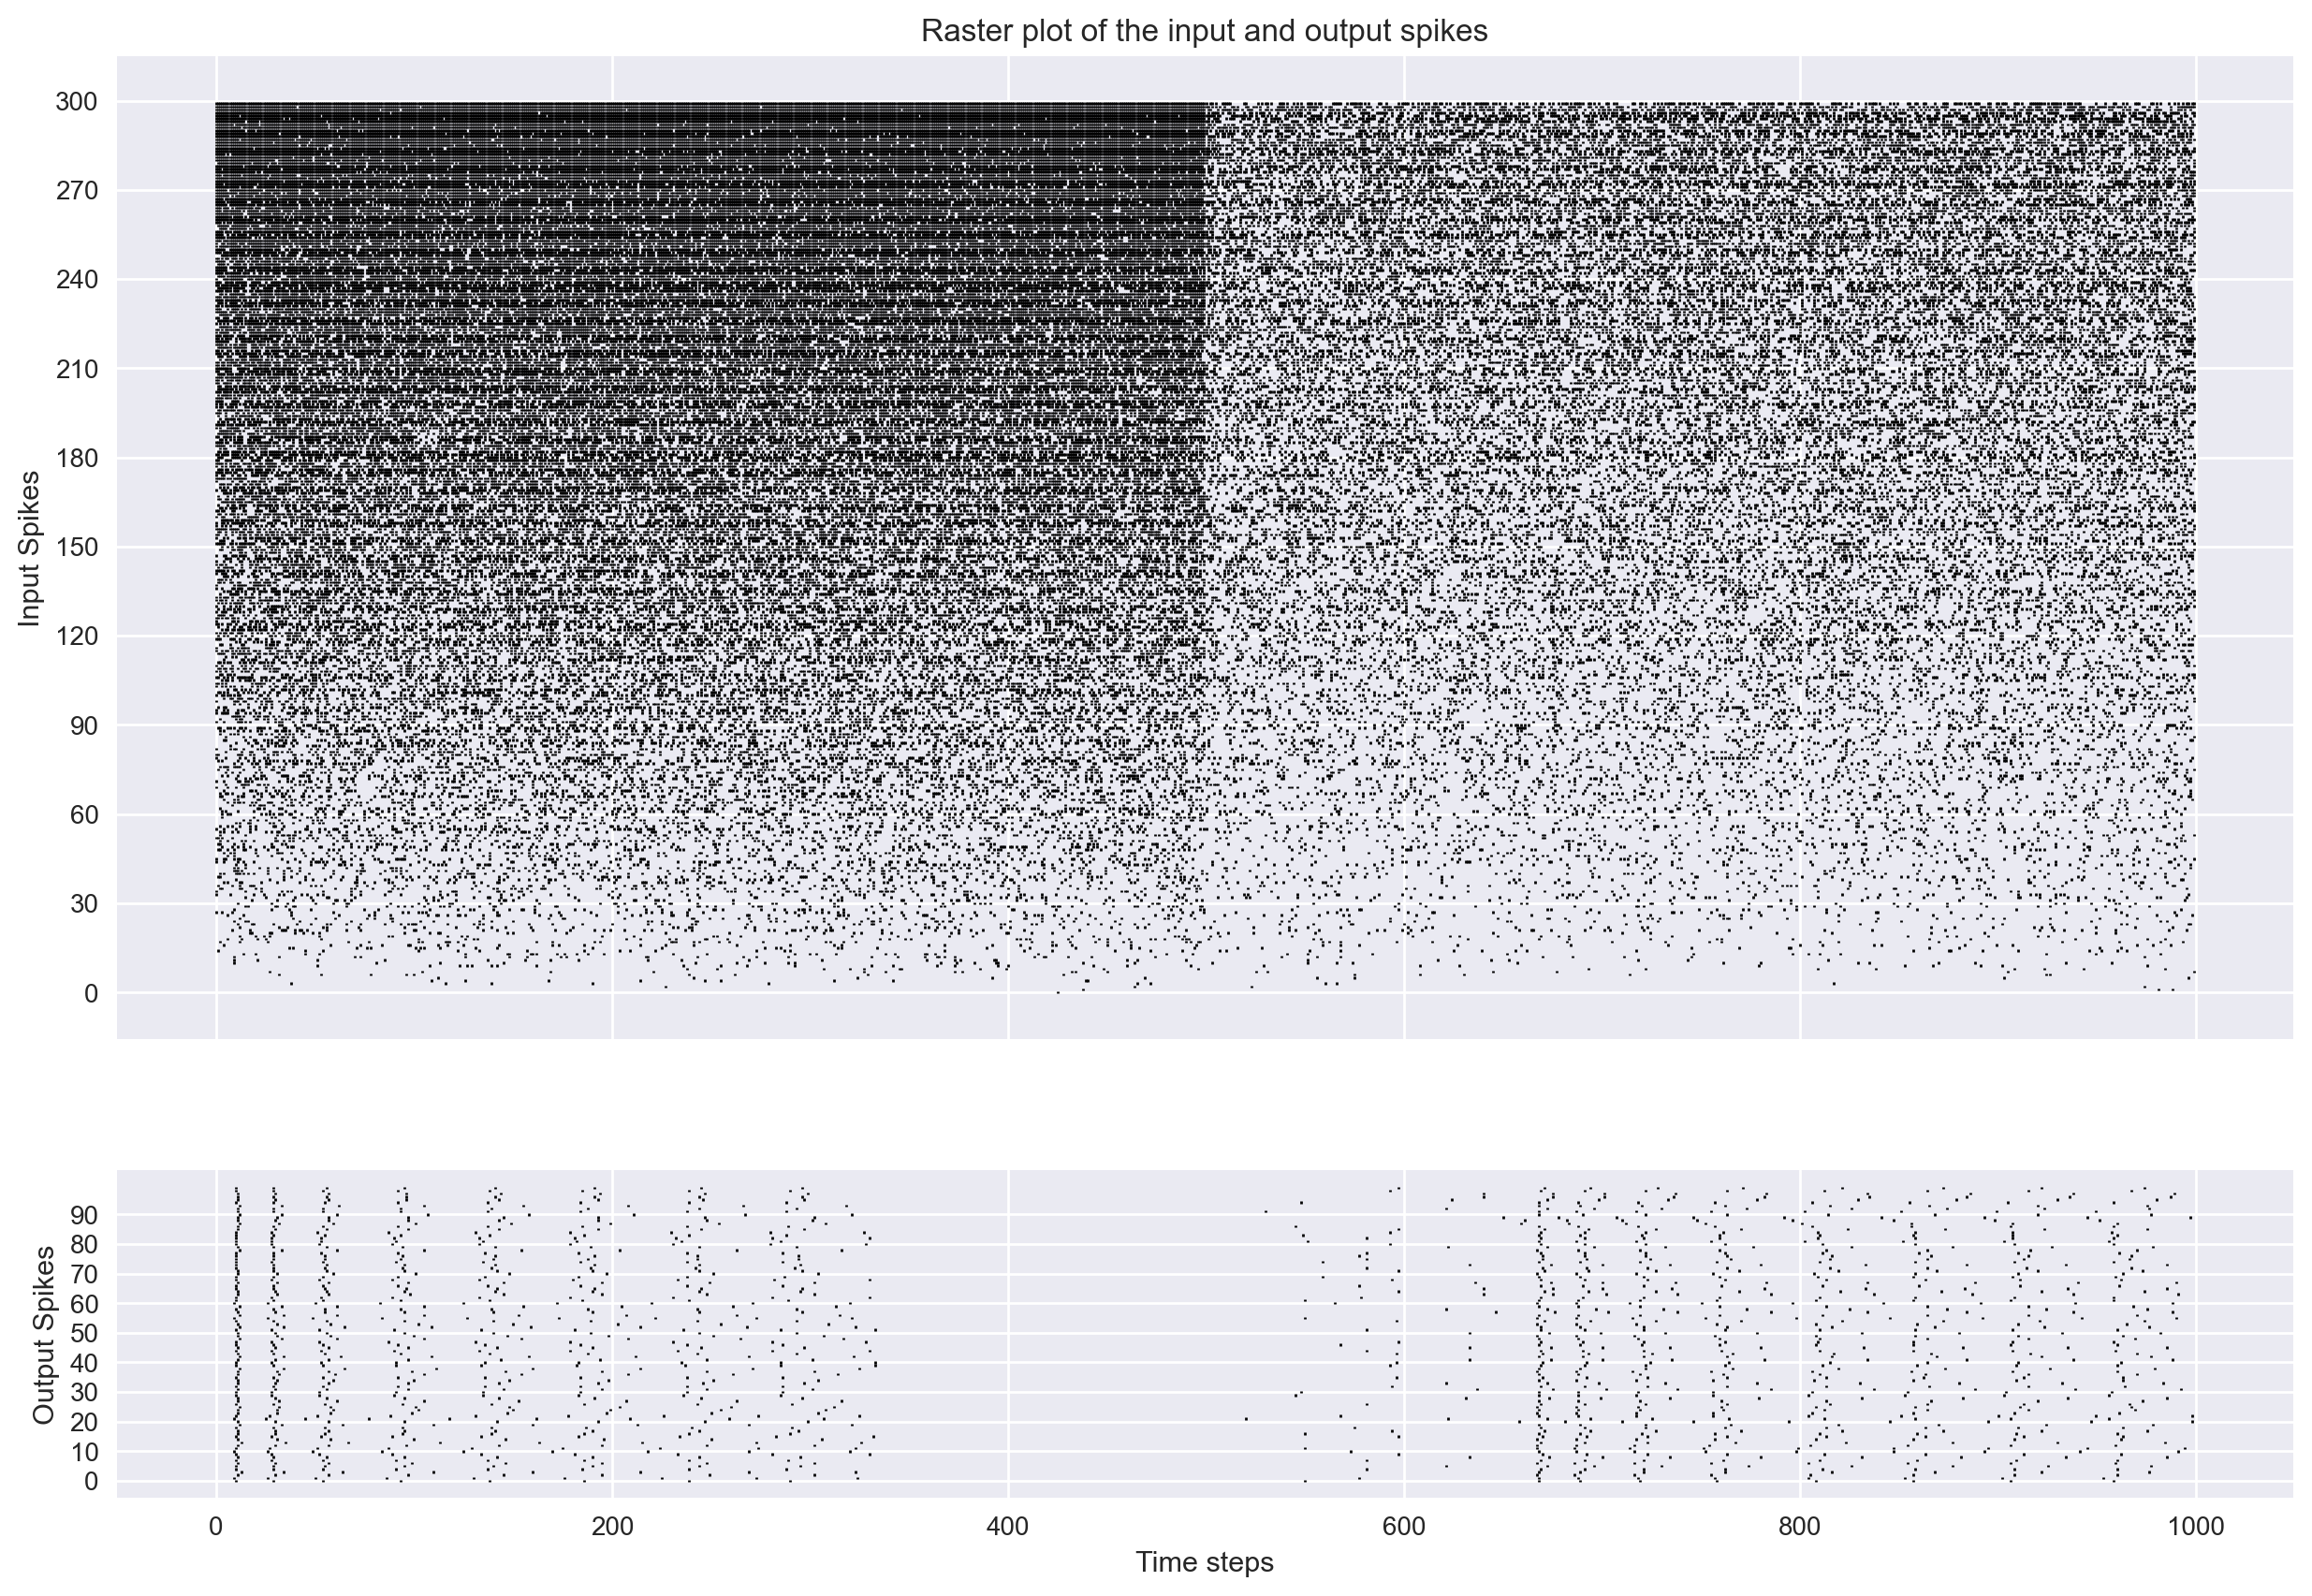

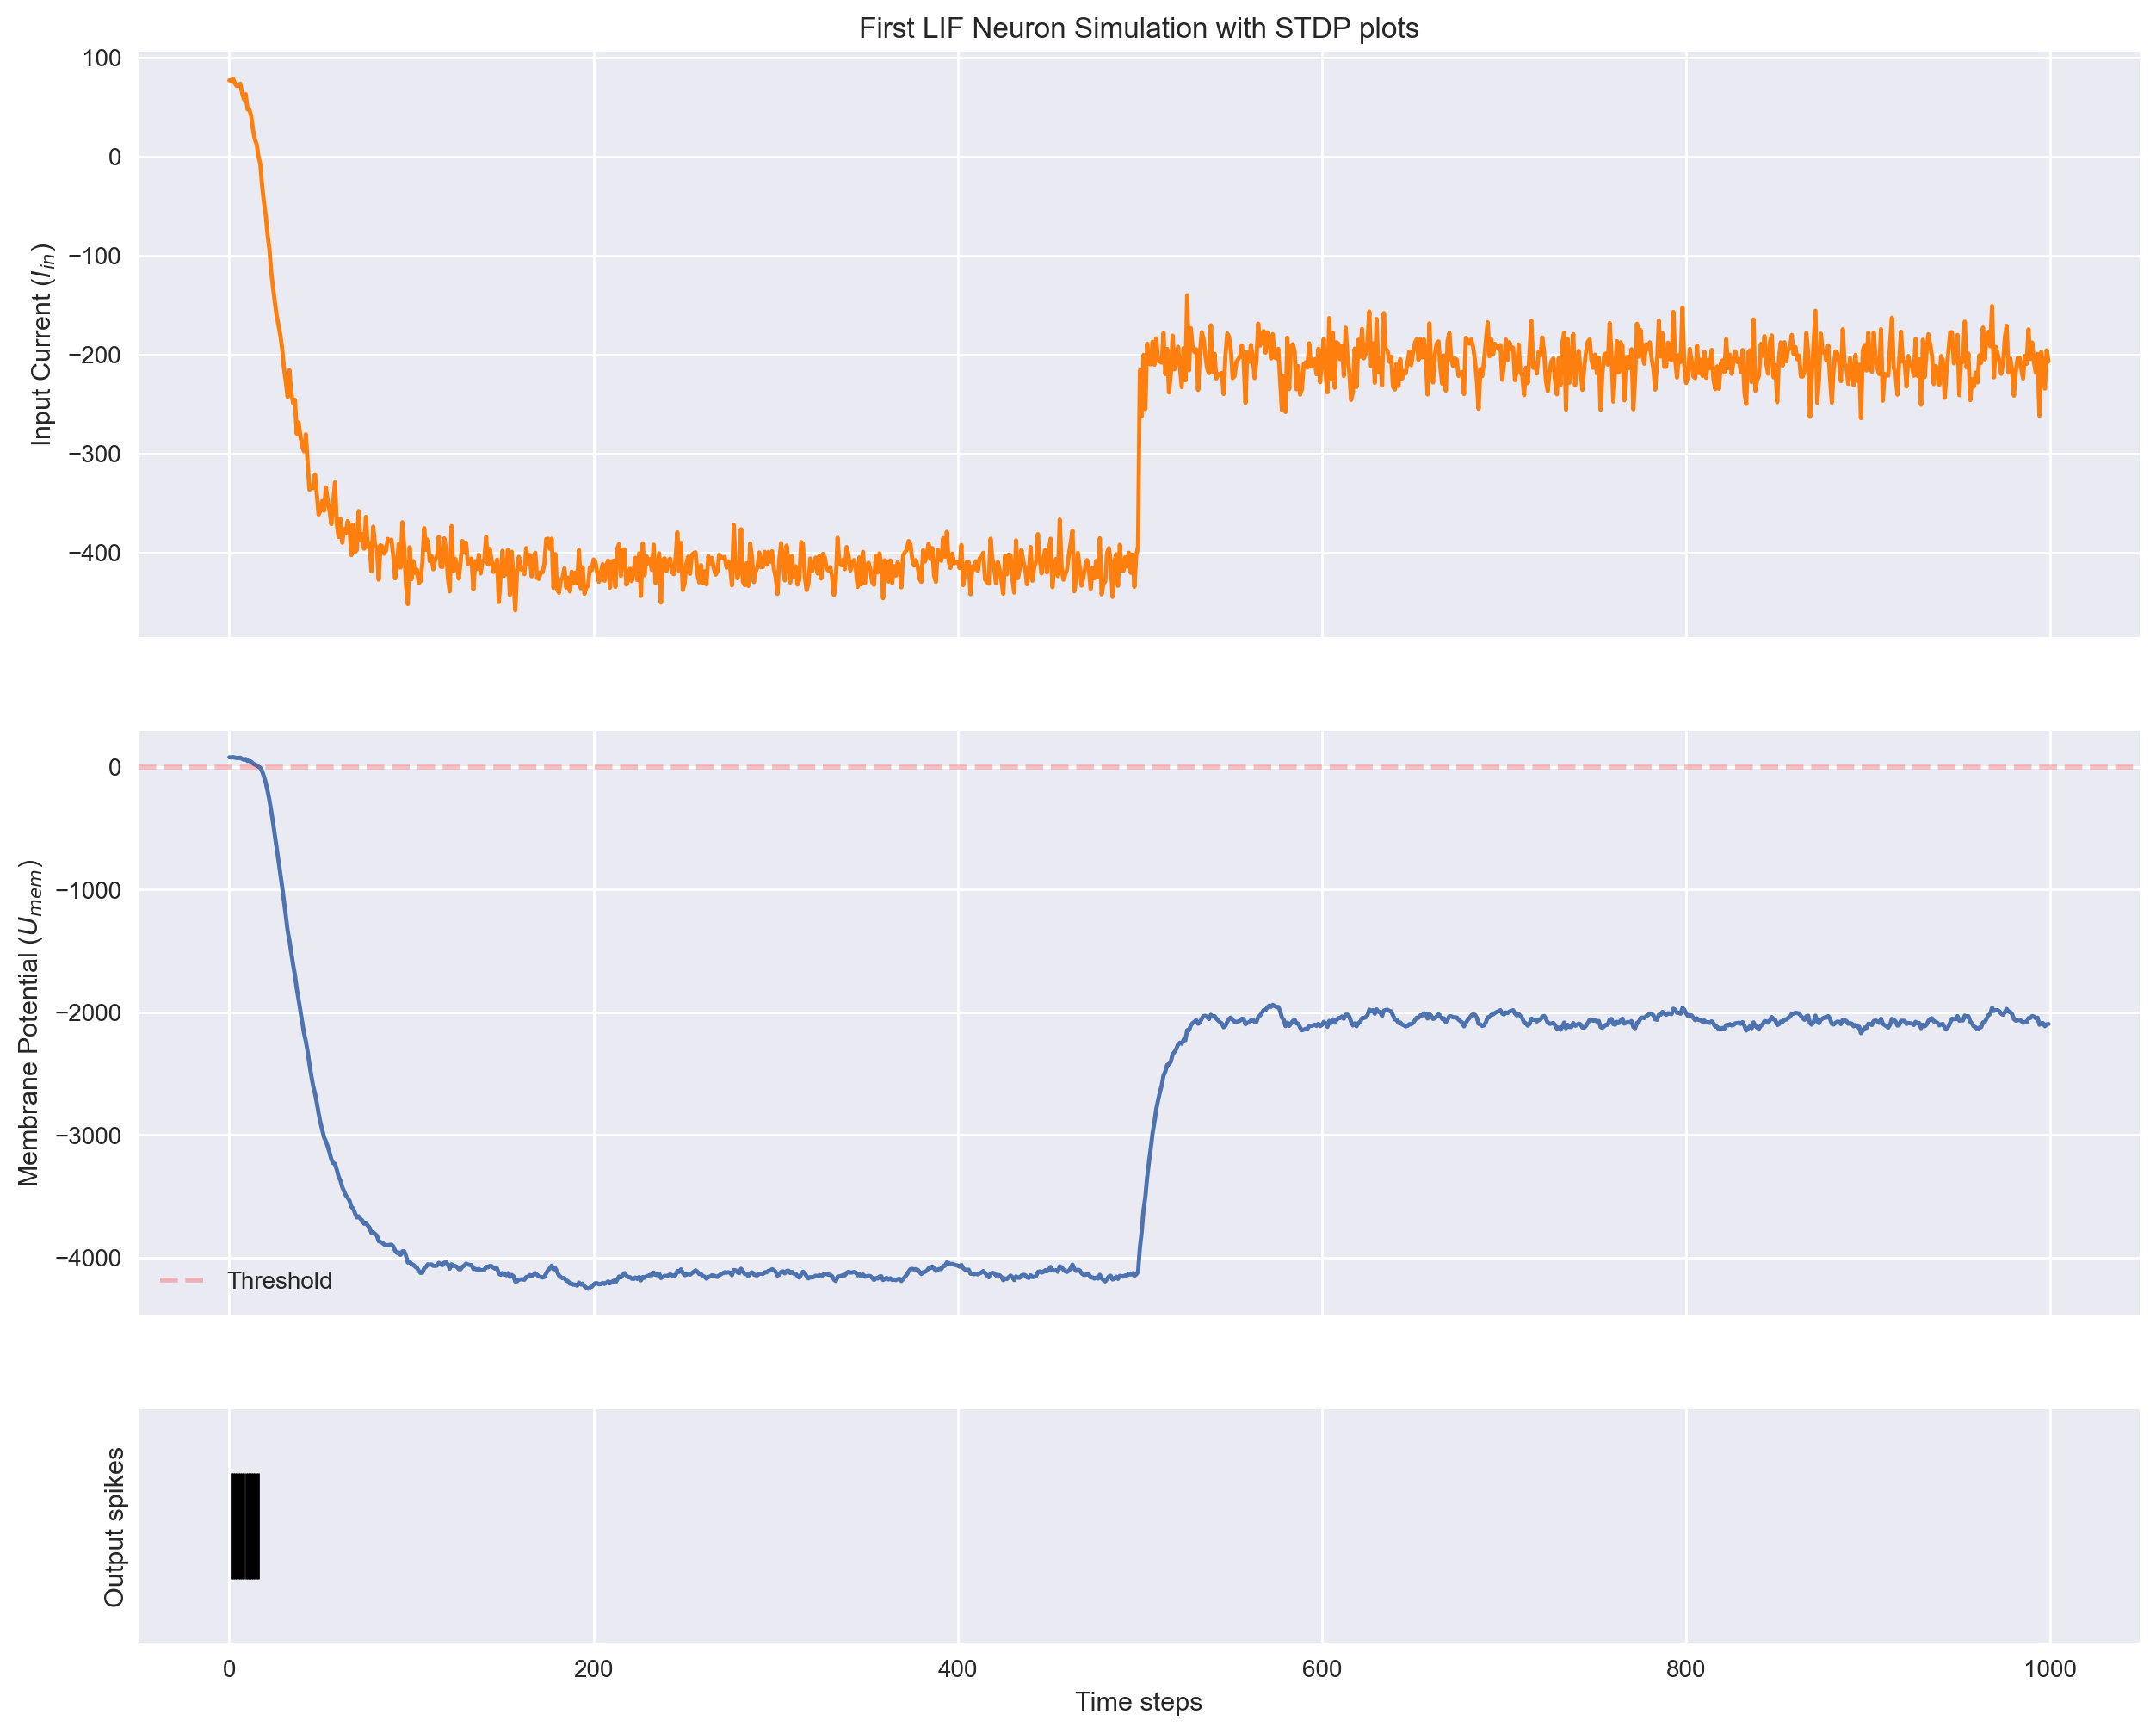

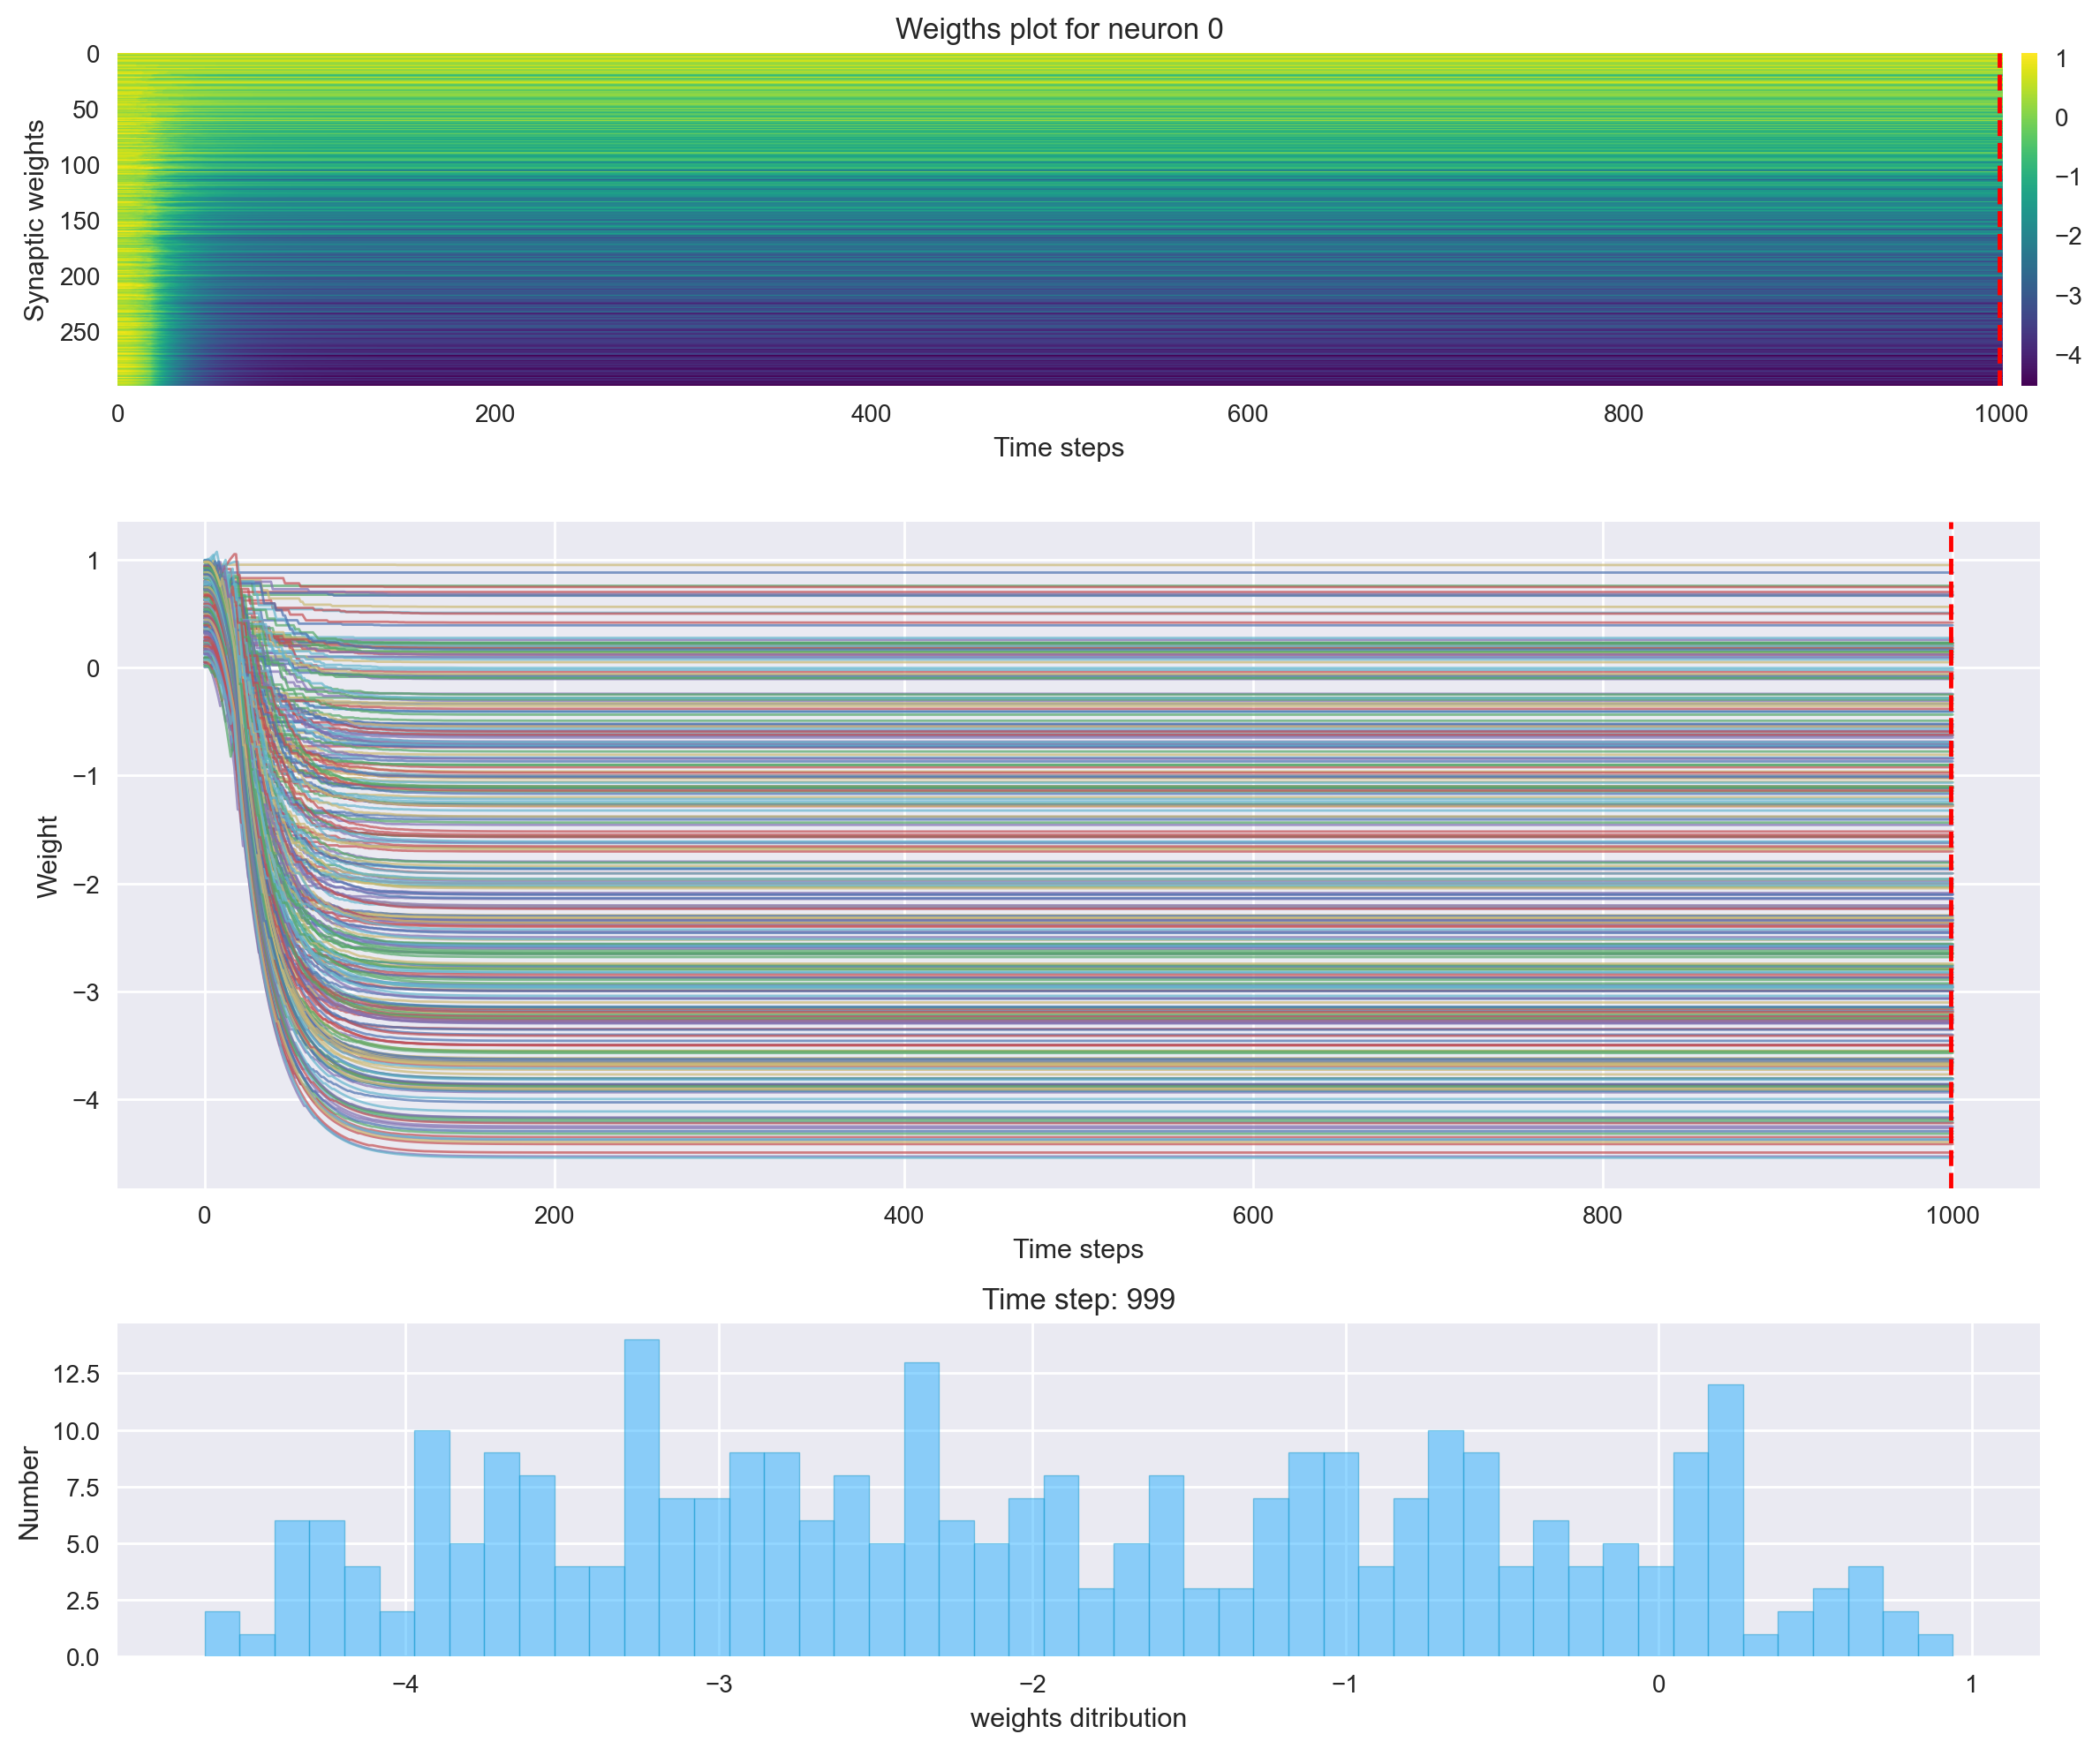

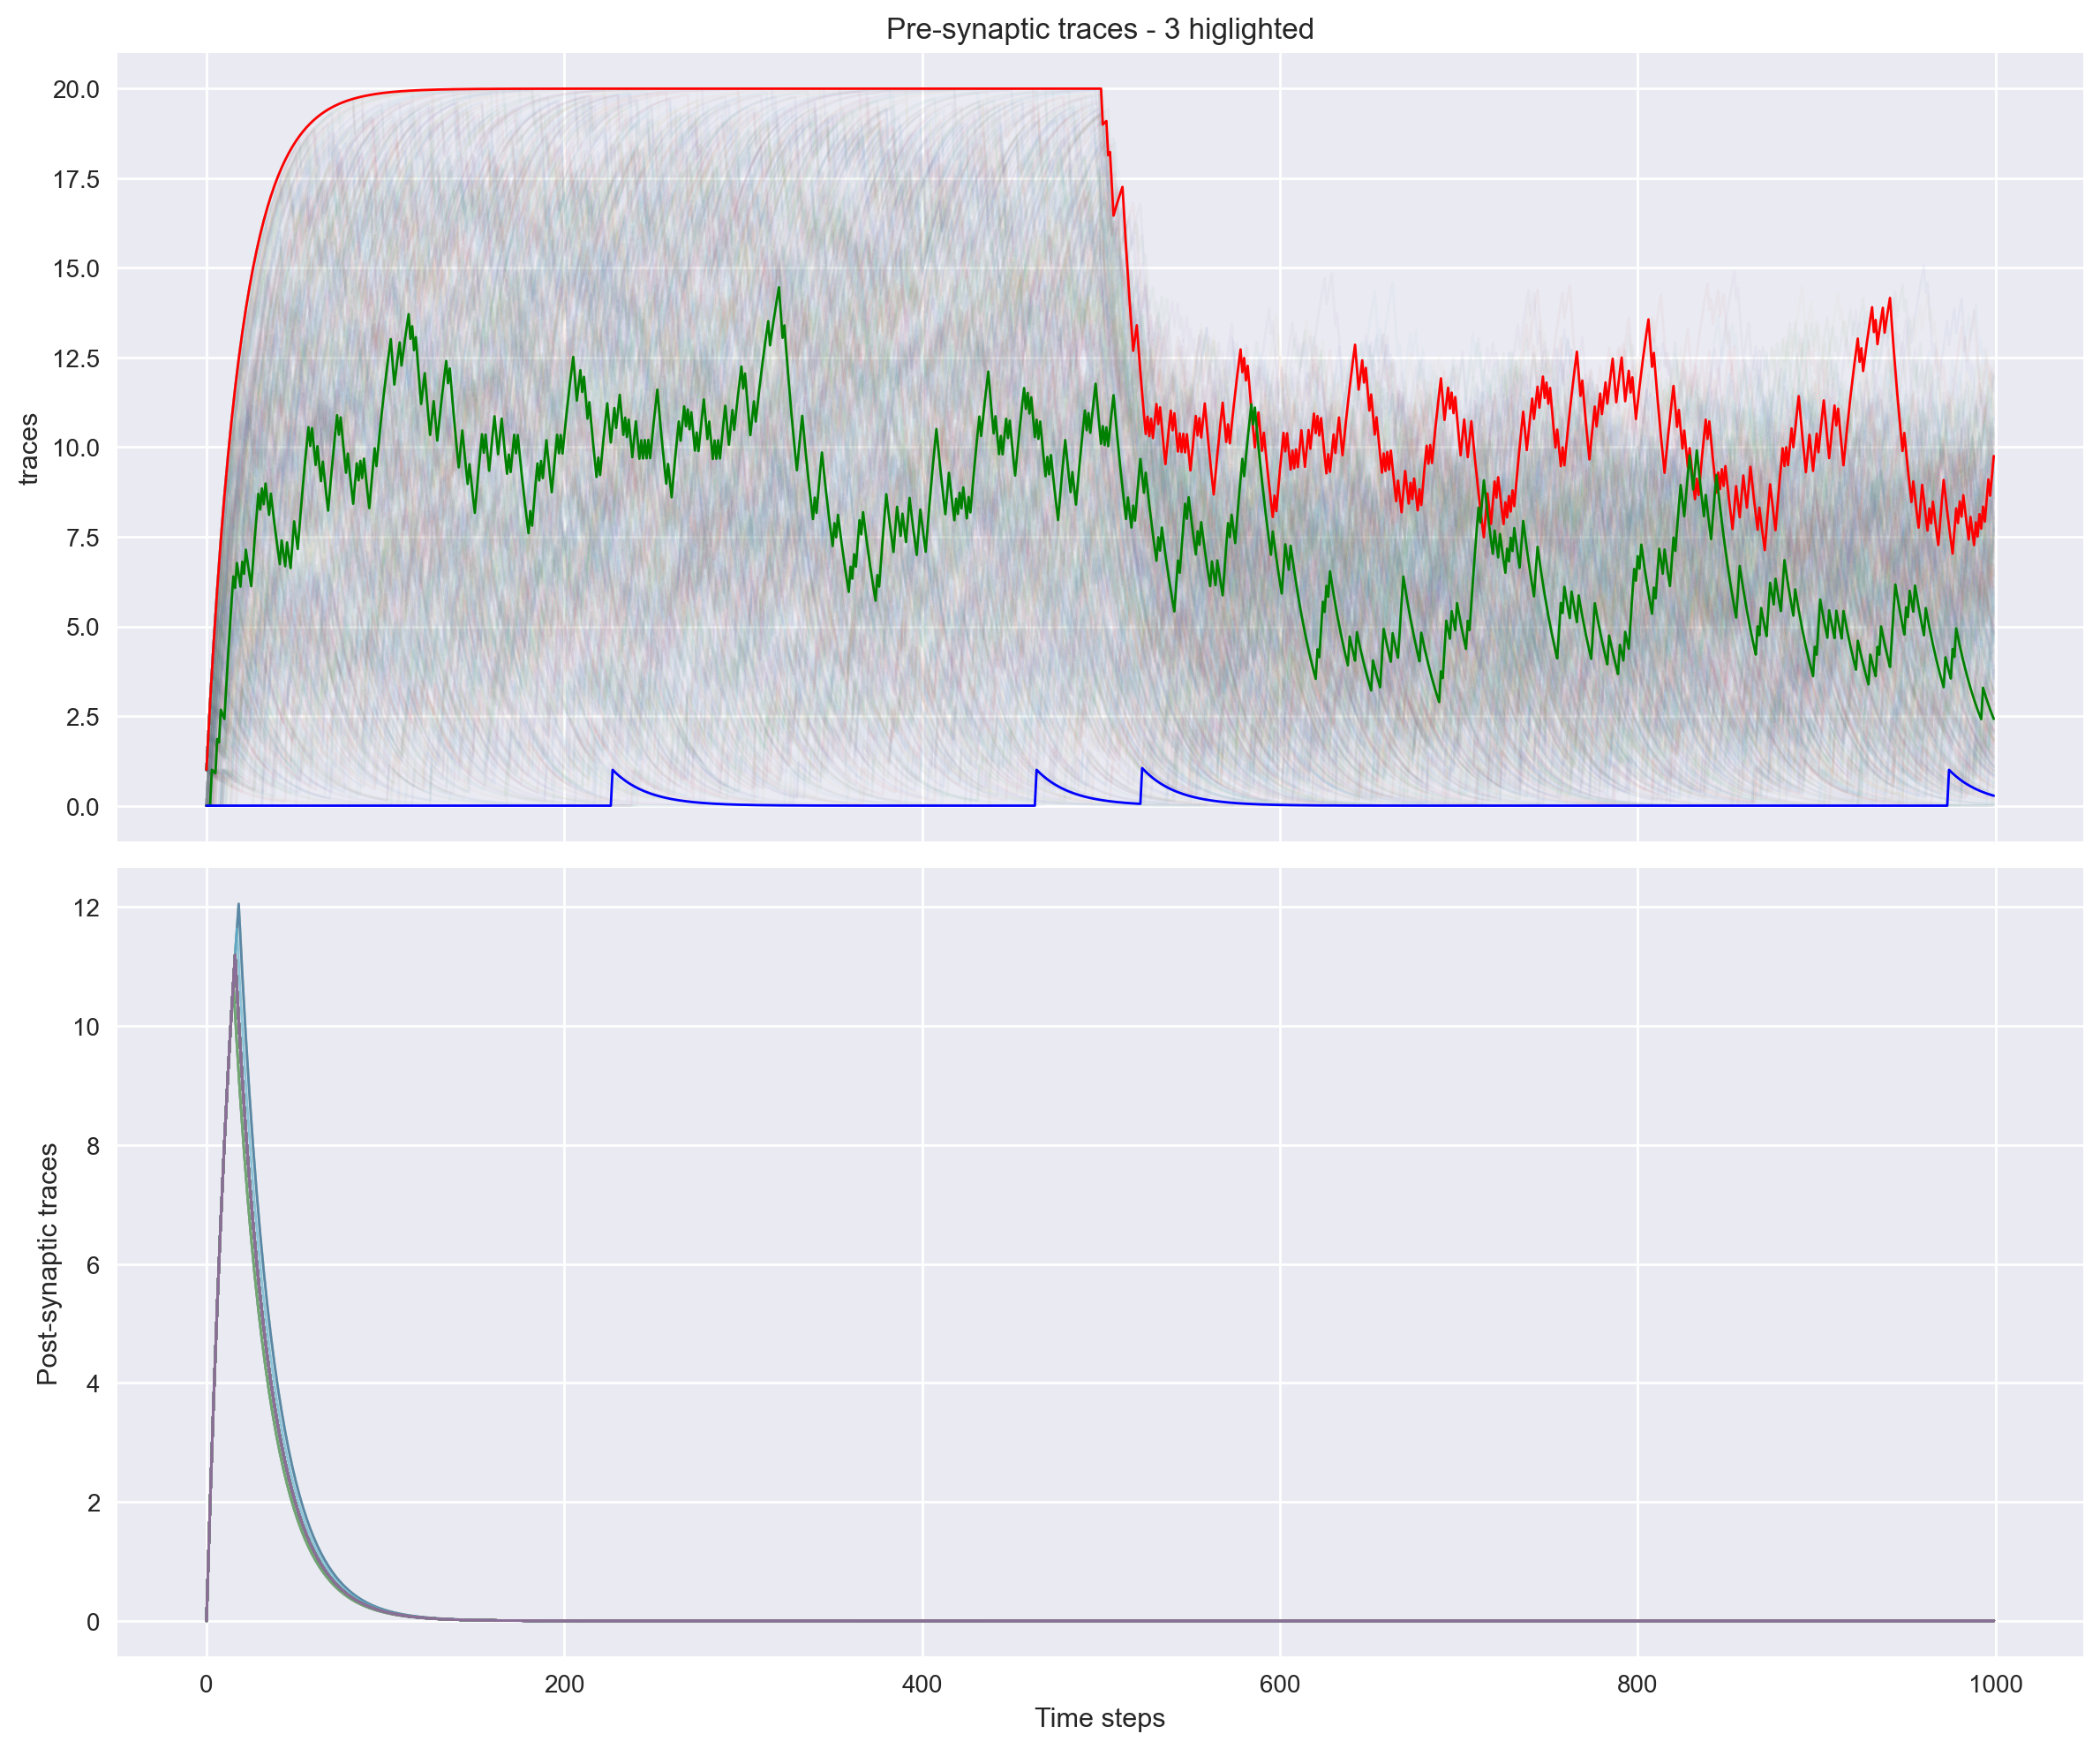

In [16]:
neuron, syn = simulation(pars, I, neuron_type = LIFNeuron, W_init=W_init, weight_rule = STDP_synapse, N_post = N_post,
                            neuron_params = {'refractory_time': False, 'dynamic_threshold': False, 'hard_reset':True},
                            weight_update_params= {'short_memory_trace':False, 'hard_constrain':'None'})


raster_plot(pars, I, np.array([neurons[i].get_records()['spk'] for i in range(N_post)]).T, title = 'Raster plot of the input and output spikes')


neuron_index = 0
neuron[neuron_index].plot_records(title="First LIF Neuron Simulation with STDP plots")

weights_plot(pars, syn.get_records()['W'][:,neuron_index,:], time_step = num_steps-1, title = f'Weights plot for neuron {neuron_index}')

weights_history = syn.get_records()['W']
pre_trace_record = syn.get_records()['pre_trace']
post_trace_record = syn.get_records()['post_trace']
time_steps = np.arange(0, len(weights_history), 1)

plot_traces(pars, pre_trace_record, post_trace_record, trace_index_list=[299,150,2])

## Interactive plots

In [60]:
def syn_plot(pars, syn, 
             manual_update = True, 
             time_step = 1, 
             subsampling = False,   
             post_index = 0,  
             time_in_ms = False):
    """
    Plot the weights changes during the simulation

    INPUT:
    - pars: parameter dictionary
    - syn: synapse object containing the weights and the traces records
    - manual_update: if True the plot is updated only when the button is pressed
    - time_step: time step to plot the distribution
    - subsampling: subsampling of the weights plot in time
    - post_index: index of the post synaptic neuron

    RETURN:
    Interactive demo, Visualization of synaptic weights
    """

    weights_history = syn.get_records()['W']
    #pre_trace_record = syn.get_records()['pre_trace']
    #post_trace_record = syn.get_records()['post_trace']
    N_post = weights_history.shape[1]
    N_pre = weights_history.shape[2]
    num_steps = weights_history.shape[0]
    
    

    # check if we want the time in ms
    if time_in_ms:
        dt=pars['dt']
        label_x = 'Time (ms)'
    else:
        dt=1
        label_x = 'Time steps'

    # time steps for the x axis
    time_steps = np.arange(0, num_steps, 1)*dt

    # set the default time step
    if time_step is None:
        time_step = num_steps-10
    elif time_step > num_steps:
        print(f'Time step must be less than {num_steps}')
        return
    
    def main_plot(time_step=time_step,
                  time_steps = time_steps, 
                  post_index = post_index,
                  subsampling = subsampling, 
                  weights_history = weights_history, 
                  label_x = label_x, 
                ):
        # check i f subsampling is less than the number of time steps
        if subsampling:
            s = num_steps//10
        else:
            s = 1

        fig,ax = plt.subplots(2, figsize=(10, 8), gridspec_kw={'height_ratios': [2, 1]})#, sharex=True)

        # plot the weights
        x = time_steps[::s]
        y = weights_history[ ::s,post_index,:]
        ax[0].plot(x, y, lw=1., alpha=0.7)
        ax[0].axvline(time_step, 0., 1., color='red', ls='--')
        ax[0].set_xlabel(label_x)
        ax[0].set_ylabel('Weight')


        # plot the weights distribution
        w_min = np.min(weights_history[time_step,:])-0.1
        w_max = np.max(weights_history[time_step,:])+0.1
        width = (w_max - w_min)/51
        bins = np.arange(w_min, w_max, width)
        #g_dis, _ = np.histogram(weights_history[time_step,:], bins)
        #ax[1].bar(bins[1:], g_dis, color='b', alpha=0.5, width=width)
        ax[1].hist(weights_history[time_step,post_index,:], bins, color='b', alpha=0.5, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
        ax[1].set_xlabel('weights ditribution')
        ax[1].set_ylabel('Number')
        #ax[1].set_title(f'Time step: {time_step}')
        plt.tight_layout()
        plt.show()

    my_layout.width = '620px'


    interactive_plot = widgets.interactive(main_plot, 
                                        {'manual': manual_update, 'manual_name': 'Update plot'},
                                        time_step=widgets.IntSlider(
                                            value = time_step, 
                                            min=0, 
                                            max=num_steps, 
                                            step=num_steps//100,
                                            description = 'Time step',
                                            layout=my_layout),
                                        time_steps = fixed(time_steps),
                                        post_index = widgets.IntSlider(
                                            min = 0,
                                            max = N_post-1,
                                            step = 1,
                                            layout=my_layout),
                                        subsampling=subsampling,
                                        weights_history = fixed(weights_history),
                                        label_x = fixed(label_x),
                                        #continuous_update=False,
                                        )
    display(interactive_plot)
    return 
    #output = interactive_plot.children[-1]
    #output.layout.height = '350px'


syn_plot(pars, syn, manual_update = False)

interactive(children=(IntSlider(value=1, description='Time step', layout=Layout(width='620px'), max=1001, step…

In [65]:
def STDP_interactive_plot(pars, I, N_post = 10,
                          manual_update = True, 
                          time_in_ms = False,
                          neuron_params = {'refractory_time': False, 'dynamic_threshold': False, 'hard_reset':True},
                          weight_update_params = {'short_memory_trace':False, 'hard_constrain':'None'}
                          ):
    
    num_steps = I.shape[0]
    # check if we want the time in ms
    if time_in_ms:
        dt=pars['dt']
        label_x = 'Time (ms)'
    else:
        dt=1
        label_x = 'Time steps'

    # time steps for the x axis
    time_steps = np.arange(0, num_steps, 1)*dt

    def simulation_plot(neuron_plot = False,
                        time_step = 1, 
                        post_index = 0,  
                        hard_constrain = 'None'
                        ):
        """
        Plot the weights changes during the simulation

        INPUT:
        - pars: parameter dictionary
        - syn: synapse object containing the weights and the traces records
        - manual_update: if True the plot is updated only when the button is pressed
        - time_step: time step to plot the distribution
        - subsampling: subsampling of the weights plot in time
        - post_index: index of the post synaptic neuron

        RETURN:
        Interactive demo, Visualization of synaptic weights
        """
        weight_update_params['hard_constrain'] = hard_constrain
        neuron, syn = simulation(pars, I, neuron_type = LIFNeuron, weight_rule = STDP_synapse, N_post = N_post,
                                neuron_params = neuron_params,
                                weight_update_params = weight_update_params)



        weights_history = syn.get_records()['W']
        
        s = 1

        fig,ax = plt.subplots(2, figsize=(10, 8), gridspec_kw={'height_ratios': [2, 1]})#, sharex=True)

        # plot the weights
        x = time_steps[::s]
        y = weights_history[1 ::s,post_index,:]
        ax[0].plot(x, y, lw=1., alpha=0.7)
        ax[0].axvline(time_step, 0., 1., color='red', ls='--')
        ax[0].set_xlabel(label_x)
        ax[0].set_ylabel('Weight')


        # plot the weights distribution
        w_min = np.min(weights_history[time_step,:])-0.1
        w_max = np.max(weights_history[time_step,:])+0.1
        width = (w_max - w_min)/51
        bins = np.arange(w_min, w_max, width)
        #g_dis, _ = np.histogram(weights_history[time_step,:], bins)
        #ax[1].bar(bins[1:], g_dis, color='b', alpha=0.5, width=width)
        ax[1].hist(weights_history[time_step,post_index,:], bins, color='b', alpha=0.5, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
        ax[1].set_xlabel('weights ditribution')
        ax[1].set_ylabel('Number')
        #ax[1].set_title(f'Time step: {time_step}')
        plt.tight_layout()
        plt.show()

        if neuron_plot:
            neuron[0].plot_records(title="First LIF Neuron Simulation with STDP plots")


        return 

    my_layout.width = '620px'
    interactive_plot = widgets.interactive(simulation_plot, 
                                        {'manual': manual_update, 'manual_name': 'Update plot'},
                                        time_step=widgets.IntSlider(
                                            min=0, 
                                            max=num_steps, 
                                            step=num_steps//100,
                                            description = 'Time step',
                                            layout=my_layout),
                                        post_index = widgets.IntSlider(
                                            min = 0,
                                            max = N_post-1,
                                            step = 1,
                                            layout=my_layout),
                                        hard_constrain = ['None',True, False],

                                        #continuous_update=False,
                                        )
    display(interactive_plot)
    #output = interactive_plot.children[-1]
    #output.layout.height = '350px'


N_pre = 30
num_steps = 100  # that is 100 milliseconds
N_post = 10
pars = simple_pars( A_plus = 0.01, A_minus = 0.019, tau_plus = 20, tau_minus = 20, w_max = 10, w_min = 0.001, R = 10)
rate = np.arange(1,N_pre+1,1)/N_pre
I = np.concatenate([Poisson_generator(pars, rate = rate, n = N_pre, num_steps = num_steps//2), Poisson_generator(pars, rate = rate/2, n = N_pre, num_steps = num_steps//2)], axis=0) 
neuron_params = {'refractory_time': False, 'dynamic_threshold': False, 'hard_reset':True}
weight_update_params = {'short_memory_trace':False, 'hard_constrain':'None'}

STDP_interactive_plot(pars, I, N_post = N_post,
                          manual_update = True, 
                          neuron_params = neuron_params,
                          weight_update_params = weight_update_params
                          )

interactive(children=(Checkbox(value=False, description='neuron_plot'), IntSlider(value=0, description='Time s…